In [1]:
%%capture
# Basics
!pip install emojis
!pip install stargazer
!pip install textstat

import emojis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns
plt.style.use("seaborn-paper")

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.ticker as ticker

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan


from textstat import flesch_reading_ease, smog_index

from stargazer.stargazer import Stargazer, LineLocation

In [2]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load data
df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/df_final.csv')
df.shape

(2351, 45)

In [4]:
# df for emoijs
df_emoijs = df[df['Total_emoijs'] > 200].copy()
df_emo = df_emoijs

In [ ]:
Counter(df_emo['emotion_gpt'])

Counter({'pride': 127,
         'determination': 156,
         'gratitude': 199,
         'optimism': 20,
         'outrage': 36,
         'neutral': 23,
         'patriotism': 18,
         'defiance': 36,
         'concern': 17,
         'hope': 10,
         'fear': 6})

## Outliers

I saw some extreme values to which the estimates are likely to be sensitive. This is why I create two dfs.

In [ ]:
# Visualise outliers
def outlier_views(df_v_f, df_emo, out_name):
  fig, axs = plt.subplots(3)

  # Boxplot for 'views'
  sns.boxplot(x=df_v_f['views'], ax=axs[1])
  axs[1].set_title('Views')
  axs[1].set(xlabel=None)  # Remove x label

  # Boxplot for 'forwards'
  sns.boxplot(x=df_v_f['forwards'], ax=axs[0])
  axs[0].set_title('Forwards')
  axs[0].set(xlabel=None)  # Remove x label

  # Boxplot for 'Total_emoijs'
  sns.boxplot(x=df_emo['Total_emoijs'], ax=axs[2])
  axs[2].set_title('Reactions')
  axs[2].set(xlabel=None)  # Remove x label

  # Show the plot
  plt.tight_layout()
  plt.savefig(f'/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Images/{out_name}.png',
              dpi=300)
  plt.show()


In [5]:
# Vis before outlier removal
outlier_views(df, df_emoijs, 'boxplots_before')

NameError: ignored

In [6]:
def remove_outliers(outcome, df=df):
  df_in = df.copy()
  Q1 = df_in[outcome].quantile(0.25)
  Q3 = df_in[outcome].quantile(0.75)
  IQR = Q3 - Q1

  df_in = df_in[~((df_in[outcome] < (Q1 - 2 * IQR)) | (df_in[outcome] > (Q3 + 2 * IQR)))]
  print(df_in.shape)
  return df_in

# Two df with outlier removes
#df_out = remove_outliers('views', df=df)
df_emo_out = remove_outliers('Total_emoijs', df=df_emoijs)

(633, 45)


In [7]:
def remove_outliers_same(df, column_names):
    df_out = df.copy()
    outlier_indices = []

    for col in column_names:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2 * IQR
        upper_bound = Q3 + 2 * IQR

        outliers = df_out[(df_out[col] < lower_bound) | (df_out[col] > upper_bound)].index
        outlier_indices.extend(outliers)

    # remove duplicates from the list of outlier indices
    outlier_indices = list(set(outlier_indices))

    # drop rows with outlier indices
    df_out = df_out.drop(outlier_indices)
    print(df_out.shape)
    return df_out

# replace ['col1', 'col2'] with the names of your two columns
df_out = remove_outliers_same(df=df, column_names=['views', 'forwards'])

(2142, 45)


In [ ]:
df.shape[0] - df_out.shape[0]

209

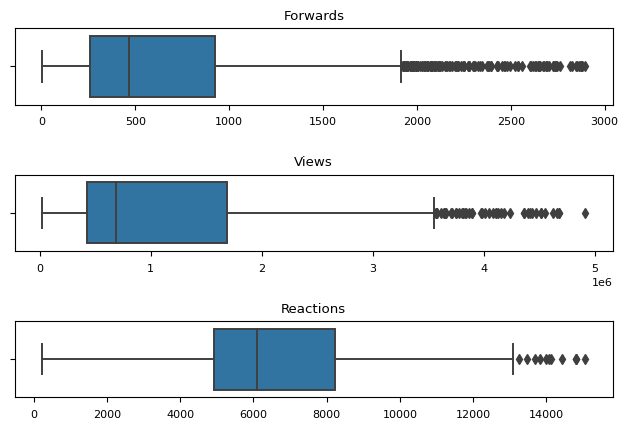

In [ ]:
# Distributions after outlier removal
outlier_views(df_out, df_emo_out, 'boxplots_after')

# Pooled OLS Analysis

Possible regression equation

$$
Y_i = \beta_0 + \sum_{j} \beta_{1j} \cdot \text{Emotion}_{ij} + \beta_2 \cdot \text{Week}_i + \beta_3 \cdot \text{Hour}_i +  \beta_4 \cdot X + \epsilon_i
$$


where $i$ indexes all messages, $i={1,...,N}$; $emotion_{i}$ is the emotion of message $i$; $X_{i}$ is a matrix text controls (e.g. topic, text length, containing URL, etc.); and $T_{i}$ is a matrix of time controls (weekly and hourly).

In [ ]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
df.index

Index(['2022-02-24 04:42:52+00:00', '2022-02-24 06:48:58+00:00',
       '2022-02-24 15:35:31+00:00', '2022-02-24 21:26:30+00:00',
       '2022-02-24 22:35:02+00:00', '2022-02-25 05:10:20+00:00',
       '2022-02-25 08:06:50+00:00', '2022-02-25 11:17:19+00:00',
       '2022-02-25 16:55:42+00:00', '2022-02-25 21:59:12+00:00',
       ...
       '2023-06-09 09:31:44+00:00', '2023-06-09 14:30:41+00:00',
       '2023-06-09 16:58:22+00:00', '2023-06-10 12:34:45+00:00',
       '2023-06-10 14:50:11+00:00', '2023-06-10 15:47:03+00:00',
       '2023-06-11 06:41:42+00:00', '2023-06-11 08:41:55+00:00',
       '2023-06-11 18:23:18+00:00', '2023-06-11 20:07:05+00:00'],
      dtype='object', name='date', length=2141)

## GPT regressions

In [ ]:
# maxlags for NW SE
int(4*(df.shape[0]/100)**(2/9))

7

In [ ]:
df.columns

Index(['date', 'Unnamed: 0.1', 'Unnamed: 0', 'id', 'message', 'views',
       'forwards', 'reactions', 'mime_type', '😢', '🙏', '❤', '👍',
       'Total_emoijs', 'message_both', 'message_split_en', 'message_split_uk',
       'message_lan', 'message_score', 'en_original', 'uk_trans',
       'message_final', 'topic', 'topic_no_outliers', 'emotion_gpt',
       'sentiment', 'x_nchars', 'x_contains_emoij', 'x_year', 'x_month',
       'x_weekofyear', 'x_monthofyear', 'x_day', 'x_weekday', 'x_hour',
       'x_weekofyear_cat', 'x_monthofyear_cat', 'russia', 'x_periodofday',
       'flesch_reading_ease', 'smog_index', 'log_views', 'log_forwards',
       'log_Total_emoijs'],
      dtype='object')

### Final reg function


In [8]:
# Functions with paramters
def final_regs(df, df_emoijs, time_dummies='x_monthofyear_cat', topic='topic', cov_type='HC3', cov_kwds={}):
  # Controls
  controls = f'C({topic}) + C(mime_type) + C(x_periodofday) + C({time_dummies}) + x_nchars + C(x_contains_emoij) + flesch_reading_ease + smog_index'

  # VIEWS

  # Emotions
  ba_gpt_views = f'log_views ~ C(emotion_gpt, Treatment(reference="neutral"))'
  co_gpt_views = f'log_views ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

  ols_ba_gpt_views = smf.ols(formula = ba_gpt_views, data=df).fit()
  ols_ba_gpt_views_rob = smf.ols(formula = ba_gpt_views, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_gpt_views_clus = smf.ols(formula = ba_gpt_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  ols_co_gpt_views = smf.ols(formula = co_gpt_views, data=df).fit()
  ols_co_gpt_views_rob = smf.ols(formula = co_gpt_views, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_gpt_views_clus = smf.ols(formula = co_gpt_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  # Sentiment
  ba_sent_views = f'log_views ~ C(sentiment, Treatment(reference="neutral"))'
  co_sent_views = f'log_views ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

  ols_ba_sent_views = smf.ols(formula = ba_sent_views, data=df).fit()
  ols_ba_sent_views_rob = smf.ols(formula = ba_sent_views, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_sent_views_clus = smf.ols(formula = ba_sent_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  ols_co_sent_views = smf.ols(formula = co_sent_views, data=df).fit()
  ols_co_sent_views_rob = smf.ols(formula = co_sent_views, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_sent_views_clus = smf.ols(formula = co_sent_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  # FORWARDS
  # Emotions
  ba_gpt_forwards = f'log_forwards ~ C(emotion_gpt, Treatment(reference="neutral"))'
  co_gpt_forwards = f'log_forwards ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

  ols_ba_gpt_forwards = smf.ols(formula = ba_gpt_forwards, data=df).fit()
  ols_ba_gpt_forwards_rob = smf.ols(formula = ba_gpt_forwards, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds) # HC3
  ols_ba_gpt_forwards_clus = smf.ols(formula = ba_gpt_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})


  ols_co_gpt_forwards = smf.ols(formula = co_gpt_forwards, data=df).fit()
  ols_co_gpt_forwards_rob = smf.ols(formula = co_gpt_forwards, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_gpt_forwards_clus = smf.ols(formula = co_gpt_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  # Sentiment
  ba_sent_forwards = f'log_forwards ~ C(sentiment, Treatment(reference="neutral"))'
  co_sent_forwards = f'log_forwards ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

  ols_ba_sent_forwards = smf.ols(formula = ba_sent_forwards, data=df).fit()
  ols_ba_sent_forwards_rob = smf.ols(formula = ba_sent_forwards, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_sent_forwards_clus = smf.ols(formula = ba_sent_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  ols_co_sent_forwards = smf.ols(formula = co_sent_forwards, data=df).fit()
  ols_co_sent_forwards_rob = smf.ols(formula = co_sent_forwards, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_sent_forwards_clus = smf.ols(formula = co_sent_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  # TOTE
  # Emotions
  ba_gpt_tote = f'log_Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral"))'
  co_gpt_tote = f'log_Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

  ols_ba_gpt_tote = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit()
  ols_ba_gpt_tote_rob = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_gpt_tote_clus = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

  ols_co_gpt_tote = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit()
  ols_co_gpt_tote_rob = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_gpt_tote_clus = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

  # Sentiment
  ba_sent_tote = f'log_Total_emoijs ~ C(sentiment, Treatment(reference="neutral"))'
  co_sent_tote = f'log_Total_emoijs ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

  ols_ba_sent_tote = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit()
  ols_ba_sent_tote_rob = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_sent_tote_clus = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

  ols_co_sent_tote = smf.ols(formula = co_sent_tote, data=df_emoijs).fit()
  ols_co_sent_tote_rob = smf.ols(formula = co_sent_tote, data=df_emoijs).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_sent_tote_clus = smf.ols(formula = co_sent_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

  return [ols_ba_sent_views_rob,
               ols_co_sent_views_rob,
               ols_ba_gpt_views_rob,
               ols_co_gpt_views_rob,
               ols_ba_sent_forwards_rob,
               ols_co_sent_forwards_rob,
               ols_ba_gpt_forwards_rob,
               ols_co_gpt_forwards_rob,
               ols_ba_sent_tote_rob,
               ols_co_sent_tote_rob,
               ols_ba_gpt_tote_rob,
               ols_co_gpt_tote_rob]

In [9]:
# Emotions
controls = 'C(topic) + C(mime_type) + C(x_hour) + C(x_weekofyear_cat) + x_nchars + C(x_contains_emoij) + flesch_reading_ease + smog_index'

# Log outcomes
# Cluster-robust: cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]}
# Robust SE: cov_type = "HC0"

# VIEWS

# Emotions
ba_gpt_views = f'log_views ~ C(emotion_gpt, Treatment(reference="neutral"))'
co_gpt_views = f'log_views ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

ols_ba_gpt_views = smf.ols(formula = ba_gpt_views, data=df).fit()
ols_ba_gpt_views_rob = smf.ols(formula = ba_gpt_views, data=df).fit(cov_type = "HC3")
ols_ba_gpt_views_clus = smf.ols(formula = ba_gpt_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

ols_co_gpt_views = smf.ols(formula = co_gpt_views, data=df).fit()
ols_co_gpt_views_rob = smf.ols(formula = co_gpt_views, data=df).fit(cov_type = "HC3")
ols_co_gpt_views_clus = smf.ols(formula = co_gpt_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

# Sentiment
ba_sent_views = f'log_views ~ C(sentiment, Treatment(reference="neutral"))'
co_sent_views = f'log_views ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

ols_ba_sent_views = smf.ols(formula = ba_sent_views, data=df).fit()
ols_ba_sent_views_rob = smf.ols(formula = ba_sent_views, data=df).fit(cov_type = "HC3")
ols_ba_sent_views_clus = smf.ols(formula = ba_sent_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

ols_co_sent_views = smf.ols(formula = co_sent_views, data=df).fit()
ols_co_sent_views_rob = smf.ols(formula = co_sent_views, data=df).fit(cov_type = "HC3")
ols_co_sent_views_clus = smf.ols(formula = co_sent_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

# FORWARDS
# Emotions
ba_gpt_forwards = f'log_forwards ~ C(emotion_gpt, Treatment(reference="neutral"))'
co_gpt_forwards = f'log_forwards ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

ols_ba_gpt_forwards = smf.ols(formula = ba_gpt_forwards, data=df).fit()
ols_ba_gpt_forwards_rob = smf.ols(formula = ba_gpt_forwards, data=df).fit(cov_type = "HC3")
ols_ba_gpt_forwards_clus = smf.ols(formula = ba_gpt_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})


ols_co_gpt_forwards = smf.ols(formula = co_gpt_forwards, data=df).fit()
ols_co_gpt_forwards_rob = smf.ols(formula = co_gpt_forwards, data=df).fit(cov_type = "HC3")
ols_co_gpt_forwards_clus = smf.ols(formula = co_gpt_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

# Sentiment
ba_sent_forwards = f'log_forwards ~ C(sentiment, Treatment(reference="neutral"))'
co_sent_forwards = f'log_forwards ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

ols_ba_sent_forwards = smf.ols(formula = ba_sent_forwards, data=df).fit()
ols_ba_sent_forwards_rob = smf.ols(formula = ba_sent_forwards, data=df).fit(cov_type = "HC3")
ols_ba_sent_forwards_clus = smf.ols(formula = ba_sent_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

ols_co_sent_forwards = smf.ols(formula = co_sent_forwards, data=df).fit()
ols_co_sent_forwards_rob = smf.ols(formula = co_sent_forwards, data=df).fit(cov_type = "HC3")
ols_co_sent_forwards_clus = smf.ols(formula = co_sent_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

# TOTE
# Emotions
ba_gpt_tote = f'log_Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral"))'
co_gpt_tote = f'log_Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

ols_ba_gpt_tote = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit()
ols_ba_gpt_tote_rob = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit(cov_type = "HC3")
ols_ba_gpt_tote_clus = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

ols_co_gpt_tote = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit()
ols_co_gpt_tote_rob = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit(cov_type = "HC3")
ols_co_gpt_tote_clus = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

# Sentiment
ba_sent_tote = f'log_Total_emoijs ~ C(sentiment, Treatment(reference="neutral"))'
co_sent_tote = f'log_Total_emoijs ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

ols_ba_sent_tote = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit()
ols_ba_sent_tote_rob = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit(cov_type = "HC3")
ols_ba_sent_tote_clus = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

ols_co_sent_tote = smf.ols(formula = co_sent_tote, data=df_emoijs).fit()
ols_co_sent_tote_rob = smf.ols(formula = co_sent_tote, data=df_emoijs).fit(cov_type = "HC3")
ols_co_sent_tote_clus = smf.ols(formula = co_sent_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

In [10]:
# Perform the Breusch-Pagan test
import statsmodels.stats.api as sms
bp_test = sms.het_breuschpagan(ols_co_gpt_forwards.resid, ols_co_gpt_forwards.model.exog)

print(f'BP test statistic: {bp_test[0]}')
print(f'BP test p-value: {bp_test[1]}')
round(bp_test[1], 2)

BP test statistic: 276.57451591149214
BP test p-value: 2.8874746948843114e-10


0.0

__Signs__ of heteroscedasticity => justify robust SE

In [ ]:
# def correct_labels(model):
#   # new index correct emotions only
#   return  [re.search(r'\.(\w+)\]', string).group(1) if 'emotion' in string else string \
#                 for string in model.params.index]

In [11]:
# Get dict of name corrections and selections of variables
def rename_covariates(model):
  '''Takes a model, returns a dict of emotion names'''
  return {em: re.search(r'T\.(\w+)\]', em).group(1) for em in model.params.index if 'neutral' in em}

# Emotions
renamed_emotions_dic = rename_covariates(ols_ba_gpt_forwards)
emotions_name_list = renamed_emotions_dic.keys()

# Sentiment
renamed_sentiments_dic = rename_covariates(ols_ba_sent_views)
sentiments_name_list = renamed_sentiments_dic.keys()

### Emotions

In [ ]:
models_emo_views = [ols_ba_gpt_views, ols_ba_gpt_views_rob, ols_ba_gpt_views_clus, ols_co_gpt_views, ols_co_gpt_views_rob, ols_co_gpt_views_clus]

# Build stargazer table
stargazer_views = Stargazer(models_emo_views)

stargazer_views.covariate_order(emotions_name_list)
stargazer_views.rename_covariates(renamed_emotions_dic)
stargazer_views.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in models_emo_views], LineLocation.FOOTER_BOTTOM)
stargazer_views.add_line('Breusch-Pagan (p-value)', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in models_emo_views], LineLocation.FOOTER_BOTTOM)
stargazer_views.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOTTOM)
stargazer_views.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOTTOM)
stargazer_views.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOTTOM)
stargazer_views.title('OLS regression: Views')
stargazer_views.show_f_statistic = False
stargazer_views.show_dof = False
stargazer_views.show_r2 = False
stargazer_views.show_residual_std_err = False
stargazer_views.dep_var_name = 'Dependent variable: views'

stargazer_views

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 145, but rank is 71
  warnings.warn('covariance of constraints does not have full '


In [ ]:
np.mean(df['views'])

1329798.315965583

In [ ]:
models_emo_forwards = [ols_ba_gpt_forwards, ols_ba_gpt_forwards_rob, ols_ba_gpt_forwards_clus, ols_co_gpt_forwards, ols_co_gpt_forwards_rob, ols_co_gpt_forwards_clus]

# Build stargazer table
stargazer_forwards = Stargazer(models_emo_forwards)

stargazer_forwards.covariate_order(emotions_name_list)
stargazer_forwards.rename_covariates(renamed_emotions_dic)
stargazer_forwards.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in models_emo_forwards], LineLocation.FOOTER_BOOTM)
stargazer_forwards.add_line('Breusch-Pagan (p-value)', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in models_emo_forwards], LineLocation.FOOTER_BOOTM)
stargazer_forwards.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_forwards.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_forwards.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_forwards.title('OLS regression: Forwards')
stargazer_forwards.show_f_statistic = False
stargazer_forwards.show_dof = False
stargazer_forwards.show_r2 = False
stargazer_forwards.show_residual_std_err = False
stargazer_forwards.dep_var_name = 'Dependent variable: forwards'

stargazer_forwards

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 141, but rank is 69
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Build stargazer table
models_emo_tote = [ols_ba_gpt_tote, ols_ba_gpt_tote_rob, ols_ba_gpt_tote_clus, ols_co_gpt_tote, ols_co_gpt_tote_rob, ols_co_gpt_tote_clus]

stargazer_tote = Stargazer([ols_ba_gpt_tote,
                            ols_ba_gpt_tote_rob,
                            ols_ba_gpt_tote_clus,
                            ols_co_gpt_tote,
                            ols_co_gpt_tote_rob,
                            ols_co_gpt_tote_clus])

stargazer_tote.covariate_order(emotions_name_list)
stargazer_tote.rename_covariates(renamed_emotions_dic)
stargazer_tote.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in models_emo_tote], LineLocation.FOOTER_BOOTM)
stargazer_tote.add_line('Breusch-Pagan (p-value)', [round(het_breuschpagan(model.resid, model.model.exog)[3], 3
                                                          ) for model in models_emo_tote], LineLocation.FOOTER_BOOTM)
stargazer_tote.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_tote.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_tote.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_tote.title('OLS reegression: Total emoijs')
stargazer_tote.show_f_statistic = False
stargazer_tote.show_dof = False
stargazer_tote.show_r2 = False
stargazer_tote.show_residual_std_err = False
stargazer_tote.dep_var_name = 'Dependent variable: total emoijs'

stargazer_tote

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 84, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### Sentiments

In [ ]:
# Build stargazer table
stargazer_sent_views = Stargazer([ols_ba_sent_views,
                                  ols_ba_sent_views_rob,
                                  ols_ba_sent_views_clus,
                                  ols_co_sent_views,
                                  ols_co_sent_views_rob,
                                  ols_co_sent_views_clus])

stargazer_sent_views.covariate_order(sentiments_name_list)
stargazer_sent_views.rename_covariates(renamed_sentiments_dic)
stargazer_sent_views.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_views.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_views.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_sent_views.title('OLS reegression: Views')
stargazer_sent_views.show_f_statistic = False
stargazer_sent_views.show_dof = False
stargazer_sent_views.show_r2 = False
stargazer_sent_views.show_residual_std_err = False
stargazer_sent_views.dep_var_name = 'Dependent variable: views'

stargazer_sent_views

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 133, but rank is 61
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Build stargazer table
stargazer_sent_forwards = Stargazer([ols_ba_sent_forwards,
                                  ols_ba_sent_forwards_rob,
                                  ols_ba_sent_forwards_clus,
                                  ols_co_sent_forwards,
                                  ols_co_sent_forwards_rob,
                                  ols_co_sent_forwards_clus])

stargazer_sent_forwards.covariate_order(sentiments_name_list)
stargazer_sent_forwards.rename_covariates(renamed_sentiments_dic)
stargazer_sent_forwards.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_forwards.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_forwards.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_sent_forwards.title('OLS reegression: Forwards')
stargazer_sent_forwards.show_f_statistic = False
stargazer_sent_forwards.show_dof = False
stargazer_sent_forwards.show_r2 = False
stargazer_sent_forwards.show_residual_std_err = False
stargazer_sent_forwards.dep_var_name = 'Dependent variable: Forwards'

stargazer_sent_forwards

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 133, but rank is 61
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Build stargazer table
stargazer_sent_tote = Stargazer([ols_ba_sent_tote,
                                  ols_ba_sent_tote_rob,
                                  ols_ba_sent_tote_clus,
                                  ols_co_sent_tote,
                                  ols_co_sent_tote_rob,
                                  ols_co_sent_tote_clus])

stargazer_sent_tote.covariate_order(sentiments_name_list)
stargazer_sent_tote.rename_covariates(renamed_sentiments_dic)
stargazer_sent_tote.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_tote.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_tote.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_sent_tote.title('OLS reegression: total emoijs')
stargazer_sent_tote.show_f_statistic = False
stargazer_sent_tote.show_dof = False
stargazer_sent_tote.show_r2 = False
stargazer_sent_tote.show_residual_std_err = False
stargazer_sent_tote.dep_var_name = 'Dependent variable: total emoijs'

stargazer_sent_tote

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 76, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### All regs and out

In [ ]:
# From manual regs
models_forwards_final = [ols_ba_sent_forwards_rob, ols_co_sent_forwards_rob, ols_ba_gpt_forwards_rob, ols_co_gpt_forwards_rob]

# Build stargazer table
stargazer_final_forwards = Stargazer(models_forwards_final)

stargazer_final_forwards.covariate_order(list(sentiments_name_list) + list(emotions_name_list))
stargazer_final_forwards.rename_covariates({**renamed_sentiments_dic, **renamed_emotions_dic})
stargazer_final_forwards.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in models_forwards_final], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.add_line('Breusch-Pagan (p-value)', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in models_forwards_final], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.add_line('Time FE', ['No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.add_line('Text controls',  ['No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.add_line('SE',  ['robust', 'robust', 'robust', 'robust'], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.title('OLS regression: Forwards')
stargazer_final_forwards.show_f_statistic = False
stargazer_final_forwards.show_dof = False
stargazer_final_forwards.show_r2 = False
stargazer_final_forwards.show_residual_std_err = False
stargazer_final_forwards.dep_var_name = 'Dependent variable: Forwards'
stargazer_final_forwards.add_custom_notes(['Parentheses report robust standard errors.'])

stargazer_final_forwards

In [ ]:
# From manual regs
model_final = [ols_ba_sent_views_rob,
               ols_co_sent_views_rob,
               ols_ba_gpt_views_rob,
               ols_co_gpt_views_rob,
               ols_ba_sent_forwards_rob,
               ols_co_sent_forwards_rob,
               ols_ba_gpt_forwards_rob,
               ols_co_gpt_forwards_rob,
               ols_ba_sent_tote_rob,
               ols_co_sent_tote_rob,
               ols_ba_gpt_tote_rob,
               ols_co_gpt_tote_rob]

stargazer_final_all = Stargazer(model_final)

stargazer_final_all.covariate_order(list(sentiments_name_list) + list(emotions_name_list))
stargazer_final_all.rename_covariates({**renamed_sentiments_dic, **renamed_emotions_dic})
stargazer_final_all.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in model_final], LineLocation.BODY_BOTTOM)
stargazer_final_all.add_line('Breusch-Pagan', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in model_final], LineLocation.BODY_BOTTOM)
stargazer_final_all.add_line('Time FE', ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'], LineLocation.BODY_BOTTOM)
stargazer_final_all.add_line('Text controls',  ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'], LineLocation.BODY_BOTTOM)
#stargazer_final_all.add_line('SE',  ['robust', 'robust', 'robust', 'robust'], LineLocation.FOOTER_BOOTM)
stargazer_final_all.show_f_statistic = False
stargazer_final_all.show_dof = False
stargazer_final_all.show_r2 = False
stargazer_final_all.show_residual_std_err = False
#stargazer_final_all.dep_var_name = 'Dependent variable: Forwards'
#stargazer_final_all.notes_label = 'Note: ' + 'Parentheses report robust standard errors. Time FE are on week level. All outcomes are log transformed.'

stargazer_final_all

In [ ]:
dir(LineLocation)

['BODY_BOTTOM',
 'BODY_TOP',
 'FOOTER_BOTTOM',
 'FOOTER_TOP',
 'HEADER_BOTTOM',
 'HEADER_TOP',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [ ]:
# save regs
# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_views.tex', 'w') as f:
#     f.write(out_tex(stargazer_views))

# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_forwards.tex', 'w') as f:
#     f.write(out_tex(stargazer_forwards))

# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_tote.tex', 'w') as f:
#   f.write(out_tex(stargazer_tote))

# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_forwards_final.tex', 'w') as f:
#   f.write(out_tex(stargazer_final_forwards))

### Final reg and robustness

__Funcionts to make multiple final regs__


In [12]:
# Run a robustness check on dominant emotions only, before semantic smoothin
df_dominant = df.groupby('emotion_gpt_before_ss').filter(lambda x: len(x) >= 25)
df_dominant.shape

(2085, 45)

In [13]:
# Functions with different specifications
# Main: outleirs removed, week dummies, robust SE, topics tbd
final_regs_main = final_regs(df_out, df_emo_out)

final_regs_with_out = final_regs(df, df_emo) # dfs with outliers
final_regs_main_week = final_regs(df_out, df_emo_out, time_dummies='x_weekofyear_cat') # main with week dummies
final_regs_main_topic = final_regs(df_out, df_emo_out, topic='topic_no_outliers') # main with no outlier topics
final_regs_main_NW = final_regs(df_out, df_emo_out, cov_type='HAC', cov_kwds={'maxlags': 7}) # main with NW SE
final_regs_main_before_ss = final_regs(df_dominant, df_emo_out) # main with NW SE

In [14]:
def final_regs_out(regs: list):
  stargazer_final_all = Stargazer(regs)

  stargazer_final_all.covariate_order(list(sentiments_name_list) + list(emotions_name_list))
  stargazer_final_all.rename_covariates({**renamed_sentiments_dic, **renamed_emotions_dic})
  stargazer_final_all.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in regs], LineLocation.FOOTER_BOTTOM)
  stargazer_final_all.add_line('Breusch-Pagan', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in regs], LineLocation.FOOTER_BOTTOM)
  stargazer_final_all.add_line('Time Dummies', ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_BOTTOM)
  stargazer_final_all.add_line('Text Controls',  ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_BOTTOM)
  #stargazer_final_all.add_line('SE',  ['robust', 'robust', 'robust', 'robust'], LineLocation.FOOTER_BOOTM)
  stargazer_final_all.show_f_statistic = False
  stargazer_final_all.show_dof = False
  stargazer_final_all.show_r2 = False
  stargazer_final_all.show_residual_std_err = False
  #stargazer_final_all.dep_var_name = 'Dependent variable: Forwards'
  #stargazer_final_all.notes_label = 'Note: ' + 'Parentheses report robust standard errors. Time FE are on week level. All outcomes are log transformed.'
  stargazer_final_all.significance_levels([0.05, 0.01, 0.001])

  return stargazer_final_all

In [15]:
# Without outlier
final_regs_out(final_regs_main)

In [ ]:
# With outlier
final_regs_out(final_regs_with_out)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 55
  warnings.warn('covariance of constraints does not have full '


In [ ]:
final_regs_out(final_regs_main_week)

In [ ]:
final_regs_out(final_regs_main_topic)

In [ ]:
final_regs_out(final_regs_main_NW)

In [ ]:
final_regs_out(final_regs_main_before_ss)

In [ ]:
# add_cols = '\\hline \\\\[-1.8ex]\n'
# print(stargazer_final_all.render_latex().replace('\\hline \\\\[-1.8ex]\n', '& \multicolumn{4}{c}{Views} & \multicolumn{4}{c}{Forwards} & \multicolumn{4}{c}{Total Emoijs} \\\\n \cline{2-5} \cline{6-9} \cline{10-13}\n'))
# #stargazer_final_all.render_latex()
# #  & \multicolumn{4}{c}{Views} & \multicolumn{4}{c}{Forwards} & \multicolumn{4}{c}{Total Emoijs} \\\n
# # \cline{2-5} \cline{6-9} \cline{10-13}

In [46]:
def out_tex(star, col=False, notes=None):
  txt = star.render_latex()
  txt = txt.replace('\\begin{table}[!htbp] \centering', '')
  txt = re.sub(r'\\caption\{.*?\}', '', txt)
  txt = re.sub(r'\\cr \\cline\{.*?\}', r' \\cr \\hline', txt)
  if col:
    txt = txt.replace("\\hline \\\\[-1.8ex]\n", "\\hline \\\\[-1.8ex]\n" +'& \multicolumn{4}{c}{Views} & \multicolumn{4}{c}{Forwards} & \multicolumn{4}{c}{Reactions} \\\\\n' + '\cline{2-5} \cline{6-9} \cline{10-13}\n', 1)
  txt = txt.replace('\\end{table}', '').strip()

  if notes:
    txt = txt.replace("\\textit{Note:} & \\multicolumn{12}{r}{$^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001} \\\\\n\\end{tabular}", "\\multicolumn{13}{p{25cm}}{Notes: " + notes + " $^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001.} \\\\\n\\end{tabular}")


  return txt

In [42]:
note_main = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

note_inc_outlier = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are included. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

note_week = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the week of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

note_topic = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic without an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

note_nw = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report Newey-West standard errors."

note_common = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Only messages labelled with common emotions are kept. In other words, messages ressigned through semantic smoothing are dropped. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

In [40]:
# print(out_tex(final_regs_out(final_regs_main), notes=note))
# "\\textit{Note:} & \\multicolumn{12}{r}{$^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001} \\\\\n\\end{tabular}"

# "\\multicolumn{13}{l}{" + note + " $^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001} \\\\\n\\end{tabular}"

__Main__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.

__Including outlier__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are included. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.


__Week Dummy__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the week of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.

__Topics Ouliters__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic without an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.

__NW__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report Newey-West standard errors.

__Common__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Only messages labelled with common emotions are kept. In other words, messages ressigned through semantic smoothing are dropped. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.

In [29]:
df['x_periodofday'].value_counts()

Afternoon    915
Morning      725
Evening      630
Night         81
Name: x_periodofday, dtype: int64

OLS regressions of take-up variables on treatment, distance and the underpopulated dummy. Group Transport dummy control included in all specifications, and an Average Distance control included with the same functional form as distance. Straight-Line Distance is
the GPS distance from the voucher holder’s house to nearest training center and is constrained to be 0 for all VBT voucher holders. Travel
Distance is the measured distance from the population centroid of the village to the training center. Controls include other treatment dummies, stipend amount dummies, household assets, household income, stitched last month, individual skill/employment/education/marital
status, as well as indicators of female empowerment. Within outcomes observations change due to missingness in control variables. Moving
from Submission to Enroll/Complete, observations change because respondents had to be randomly balloted out after submission due to
course capacity constraints. Observations change relative to Table 4 as not all households had GPS data to map their paths. The variable
Dummy: 500m Segment ≤ 50th %ile Pop. Density is equal to 1 when the path has 500 meters or more in which the population density
is below the median. Paths are calculated from the cluster centroid to the nearest training center. All percentage changes relative to
Table 4 with the restricted sample are significant at the 95%. These are calculated using a nested model F-test, testing the inclusion of
the dummy. Standard errors clustered at the village level reported in parentheses. * p<0.10, ** p<0.05, *** p<0.01

In [48]:
# # Save regs

# # Main specification
# # with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_final.tex', 'w') as f:
# #   f.write(out_tex(stargazer_final_all, col=True))

with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_main.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main), col=True, notes=note_main))

# Robustness: outlier
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_outlier.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_with_out), col=True, notes=note_inc_outlier))

# Robustness: time dummy
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_week.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main_week), col=True, notes=note_week))

# Robustness: topic outliers
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_topic.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main_topic), col=True, notes=note_topic))

# Robustness: NW
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_nw.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main_NW), col=True, notes=note_nw))

# Robustness: Drop rare emotions
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_before_ss.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main_before_ss), col=True, notes=note_common))

# # TEST: table note
# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_note.tex', 'w') as f:
#   f.write(out_tex(final_regs_out(final_regs_main), col=True, notes=note))


# Time Series Model

## Basic AR models

My current idea is to use Autoregression modelling where the DGP is modelled as

$$
y_{t} = \delta + \phi_{1}y_{t-1} + ... +\; \phi_{p}y_{t-p} + \epsilon_{t}
$$

where the complete specification is given by

$$
y_{t} = \delta_{0} + \delta_{1}t + \phi_{1}y_{t-1} + ... +\;\phi_{p}y_{t-p} + \sum_{i=1}^{s-1} \gamma_{i}d_{i} + \sum_{j=1}^{m} \kappa_{j}x_{t,j} + \epsilon_{t}
$$

- $t$ is the time trend (1,2,...)

- \phi_{t-p} coefficients of the lags

- $d_{i}$ is a dummy for season effects

- x_{t,j} are exogenous regressors

Source: https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html

AR models


## Basic ARMA

ARMA models are used when data is stationary and autocorrelation is present, that is, when values depend on its past values. Useful when we suspect AR and MA:

1. __AR__: y_{t} is influenced by previous ys'. Motivation: views of message t are dependent on views of message in t-1. For example, when a message receives a high number of views in t-1, then it is likely that it also receives a high number of views in t (e.g. because people engage more with those messages).

  __DO__ check idea of the coefficient of the lagged y

2. __MA__: e_{t} is influenced by previous es'. Motivation: error term captures events or shocks that are not captured in the model. Those things in the past are likely to influence the number of views in t. For example, events in the war can lead to changes in the views, and we can imagine that those shocks in t-1 can certainly influence y in t.

Taken together, MA and RA help to model or to control for the temporal dependencies of in views

__Do__ Find the number of right lags considering a model criterion such as AIC and BIC
Extension to ARMAX, i.e. ARMA with X.

## Suggested ARMAX Regression

$$
y_{t} = \alpha + \sum_{j=1}^{m} \beta_{j}emotion_{t,j} + \gamma X_{t} + \sum_{i=1}^{p} \delta_{i}Y_{t-i} + \epsilon_{t} + \sum_{i=1}^{q} \rho_{i}\epsilon_{t-i}
$$

- $y_{t}$ represents the views at time t,

- $\alpha$ is a constant term,

- $\sum_{j=1}^{m} \beta_{j}$ emotion_{t,j} is the effect of various emotion dimensions (m of them) at time t on views,

- $\gamma X_{t}$ could be used to represent the effect of any other control variables at time t on views,

- $\sum_{i=1}^{p} \delta_{i}Y_{t-i}$ represents the AR part of the model, capturing the effect of views at the previous p time points on views at time t,

- $\epsilon_{t}$ is the error term at time t,

- $\sum_{i=1}^{q} \rho_{i}\epsilon_{t-i}$ represents the MA part of the model, capturing the effect of the error terms (or shocks) at the previous q time points on views at time t.


This is without time dummies. My argument would be to include them, as they capture differences in the outcome based on week/month. The AR/MA components do cpature effects of previous messages, but not entire weeks or months.

## Exploratory Analysis

Important to do to understnad the time seires nature of the data, to determine the parameters for AR and MA.

1. Check stationary: AR and ARMA assume the data to be stationary

2. Check ACF and PACF:
  Source: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf/notebook
  - PACF: determines the AR order
  - ACF: determines the MA order
  - Both and ARMA assume stationary (tested in the previous step)

  Autocorrelation function (ACF): shows the correlation of value in t, with the values of t-k.

  Partial ACF (PACF):  

In [ ]:
df['diff_forwards'] = df['forwards'].diff().fillna(0)
df['diff_views'] = df['views'].diff().fillna(0)

In [ ]:
def vis_stationary(outcome):
  # https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda

  plt.figure(figsize=(25,5))
  plt.plot(df[outcome])
  plt.title(f'{outcome} Over Time')
  plt.xlabel('Time')
  plt.ylabel(f'{outcome}')
  plt.show()

def check_mean_std(outcome):
    #Rolling statistics
    rolmean = pd.Series(df[outcome]).rolling(window=6).mean()
    rolstd = pd.Series(df[outcome]).rolling(window=6).std()
    plt.figure(figsize=(22,10))
    orig = plt.plot(df[outcome], color='red',label='Original', alpha=0.2)
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean ")
    plt.title(f'{outcome} Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

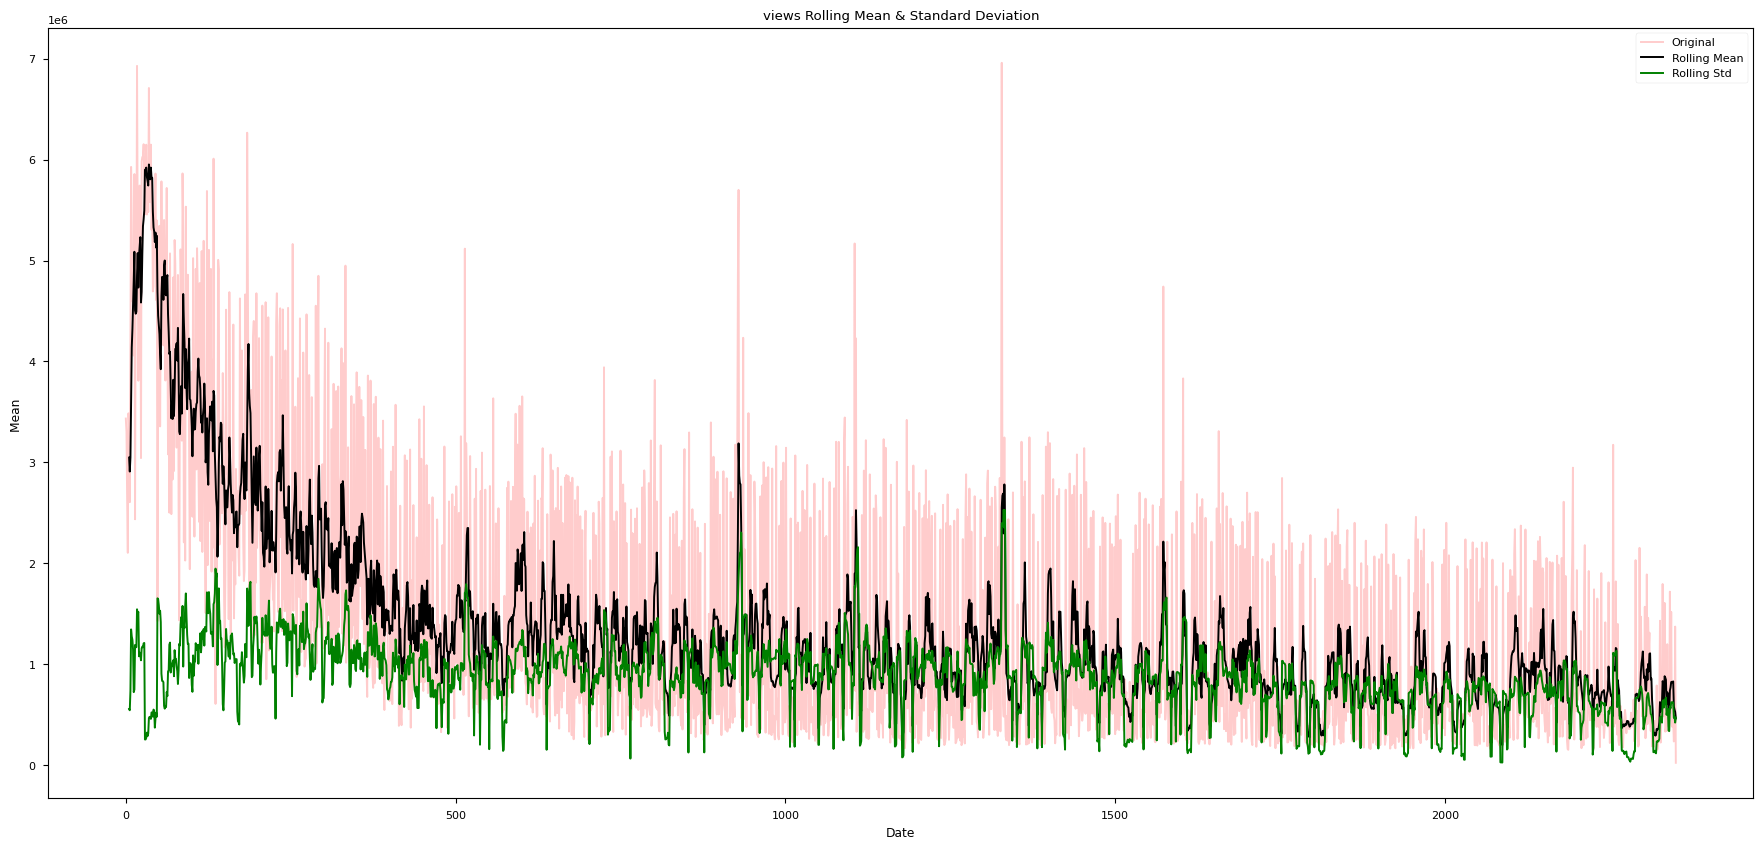

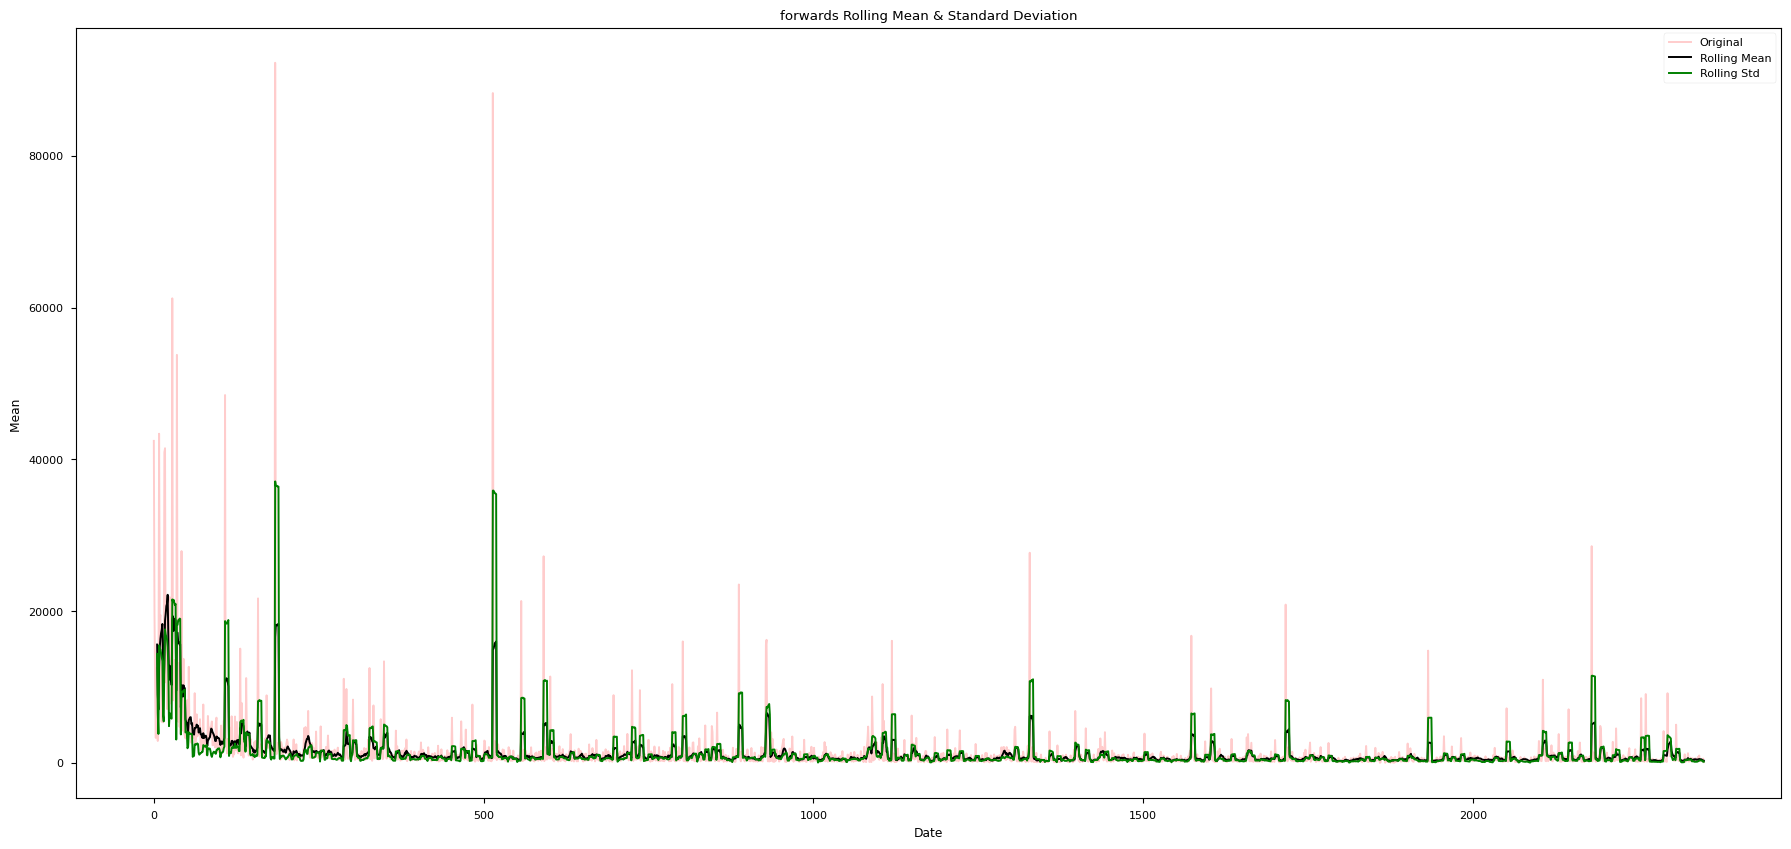

In [ ]:
# Original outcomes
check_mean_std('views')
check_mean_std('forwards')

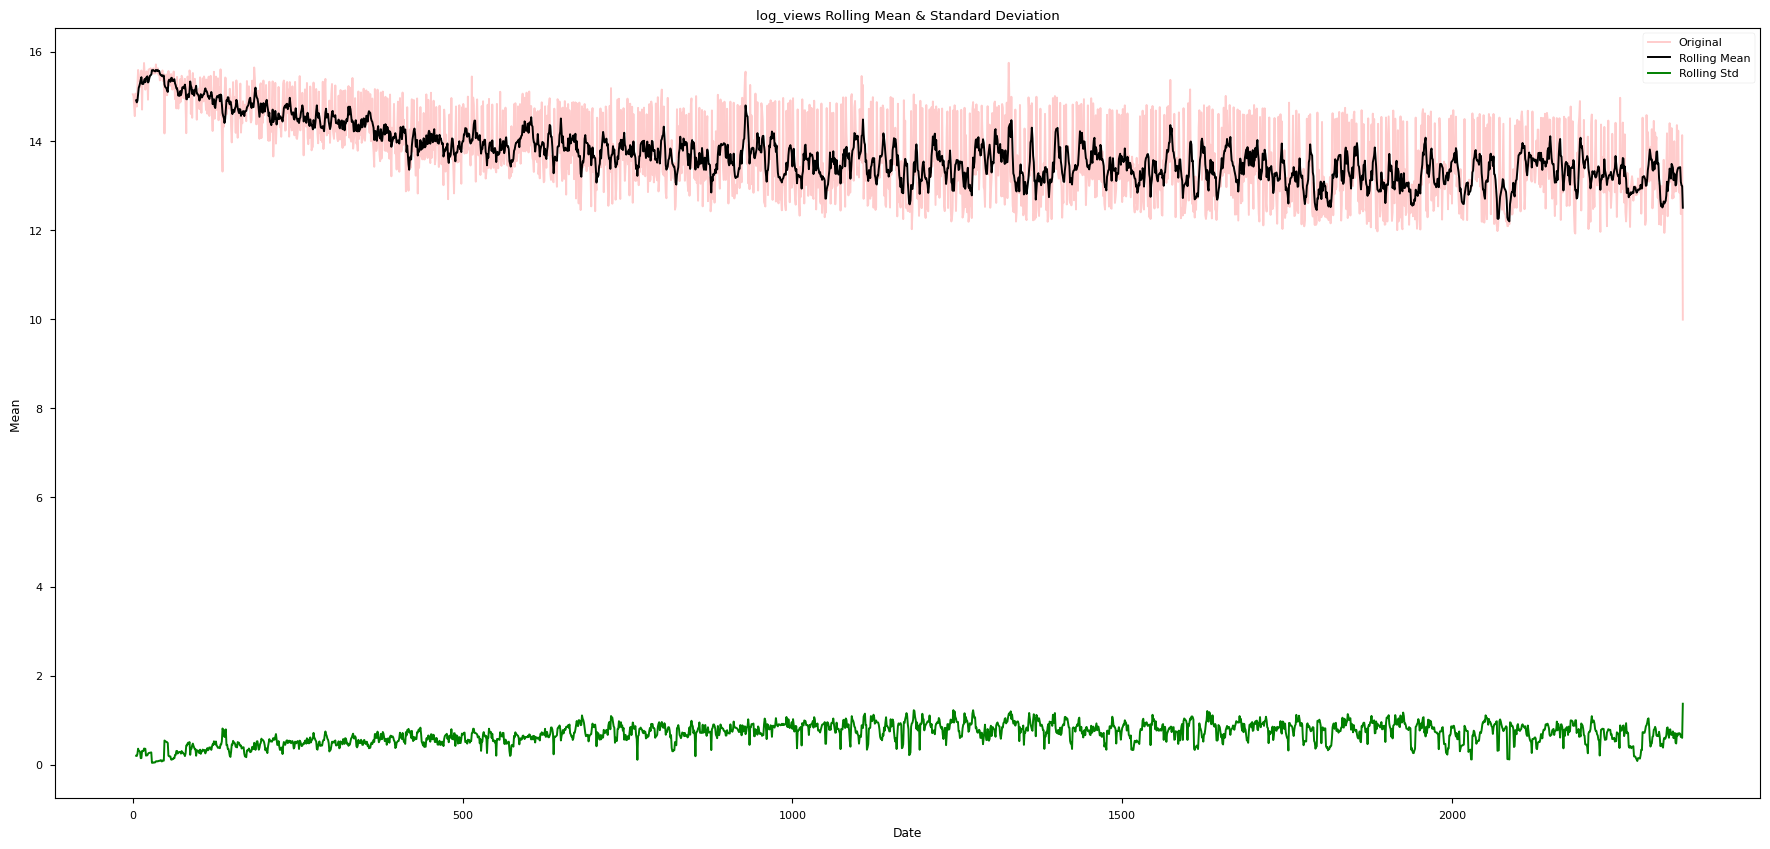

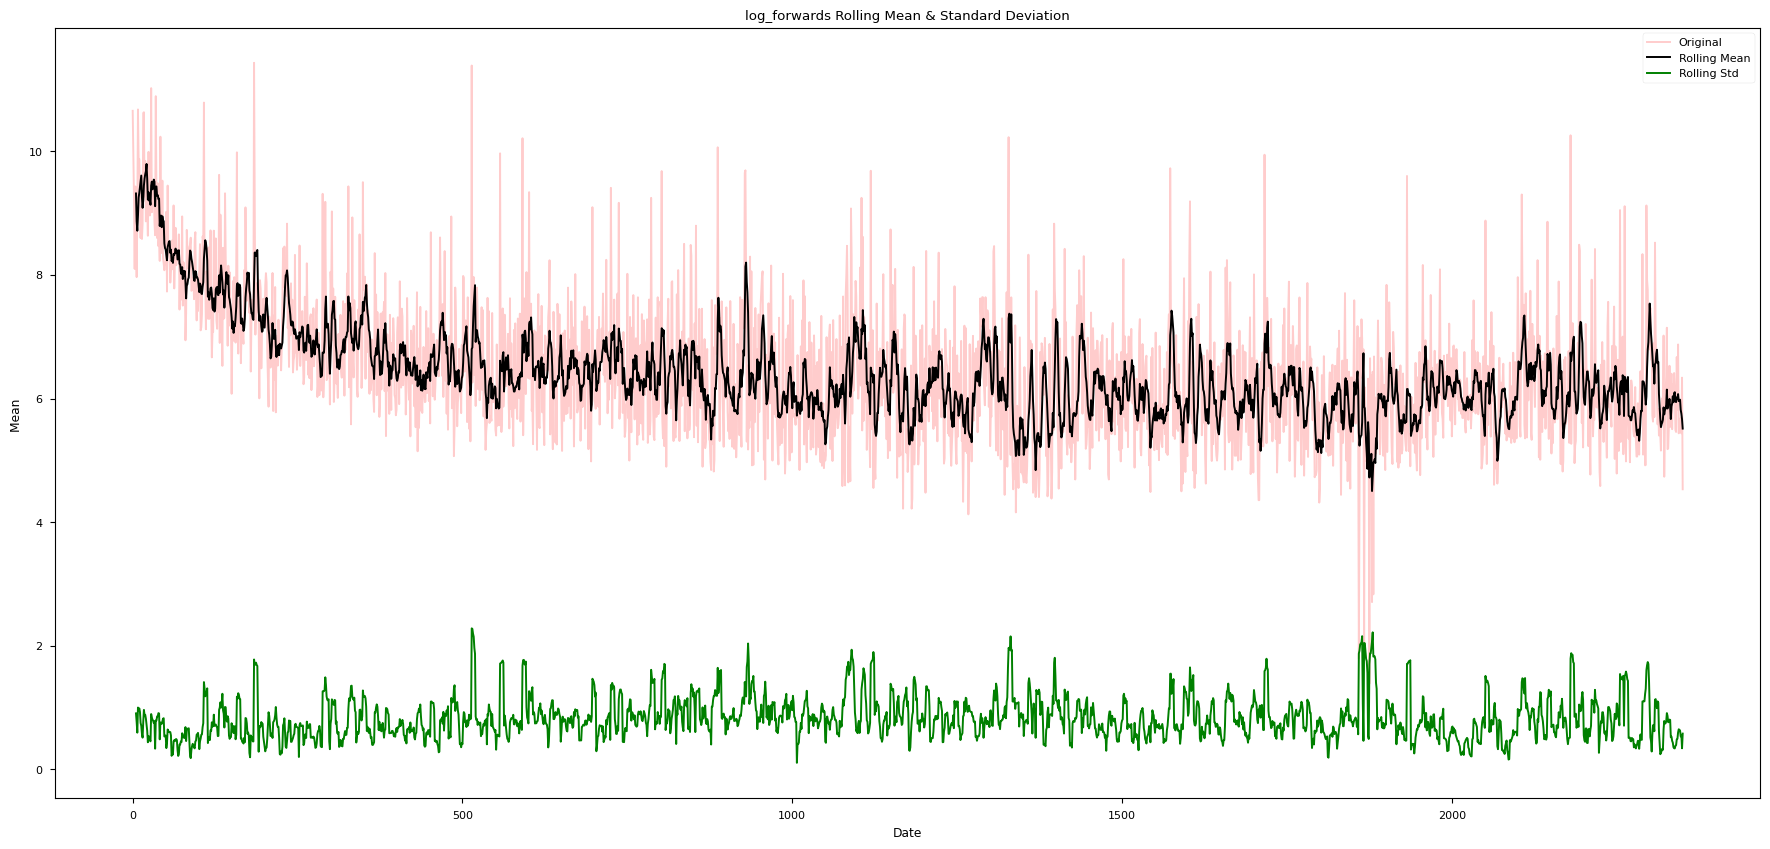

In [ ]:
# Log outcomes
check_mean_std('log_views')
check_mean_std('log_forwards')

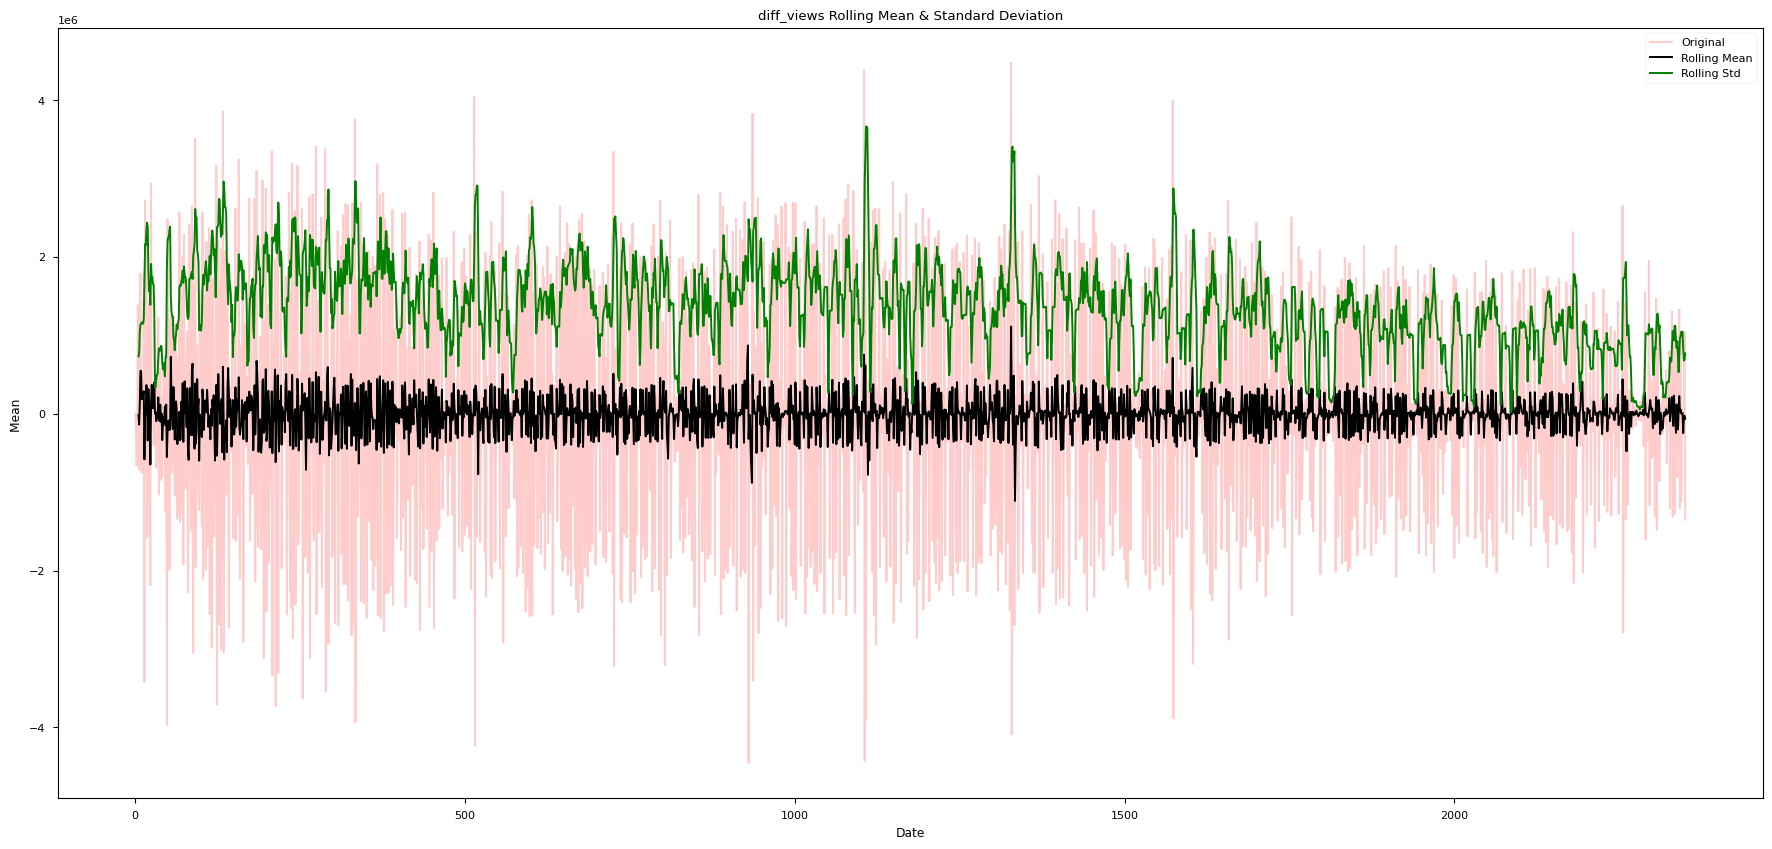

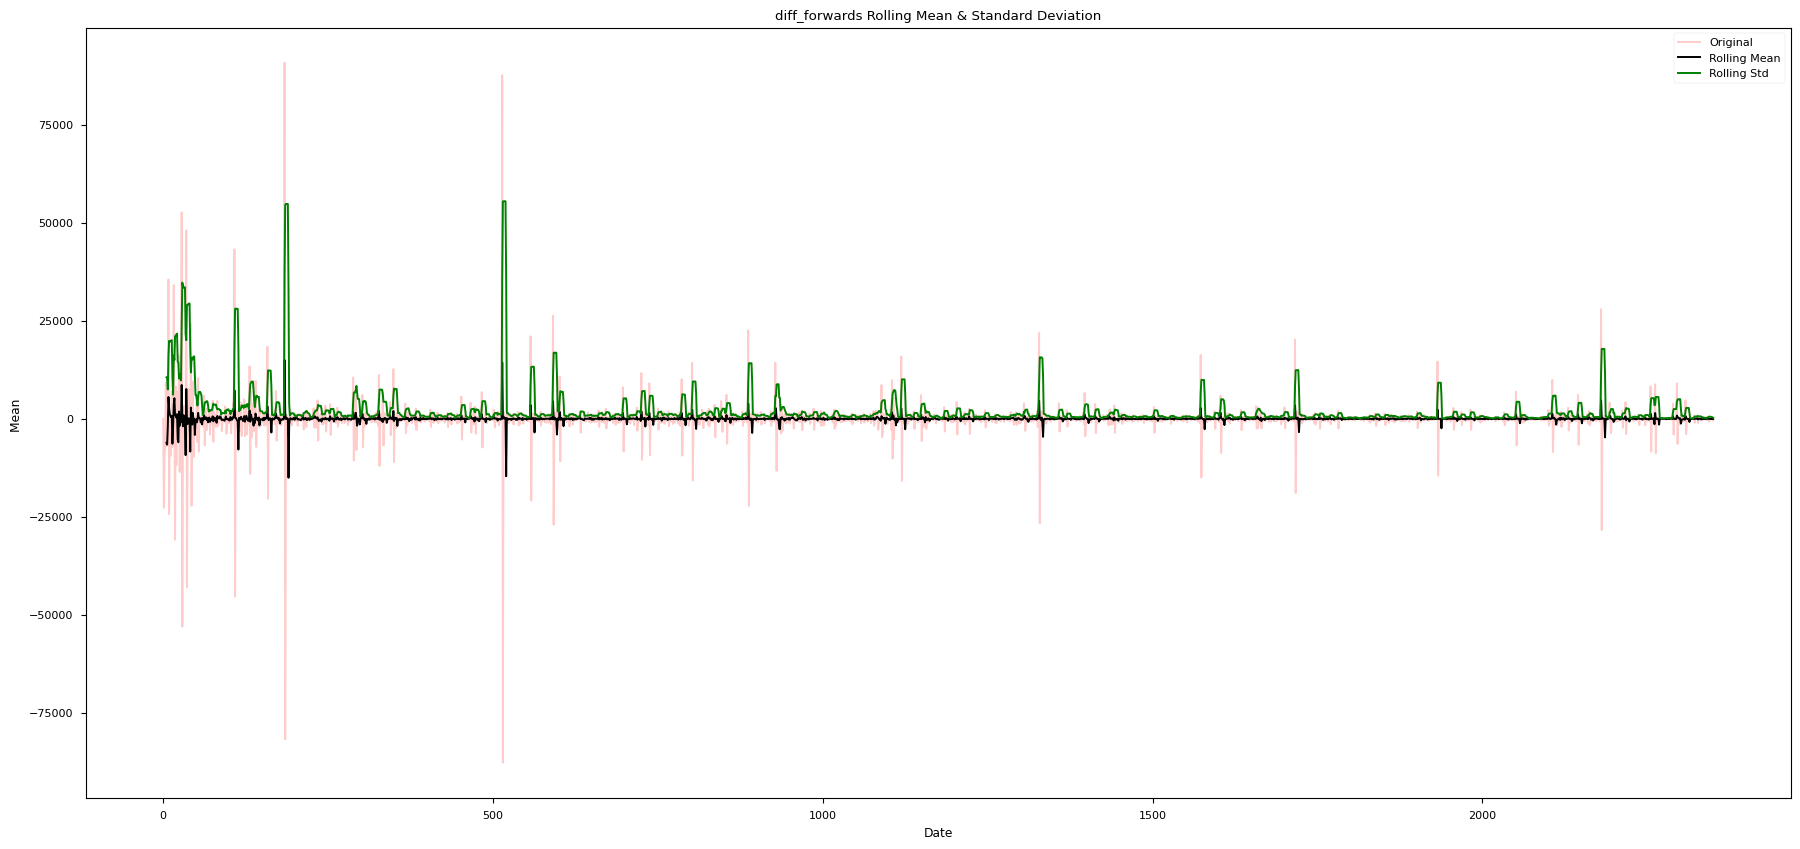

In [ ]:
# Log outcomes
check_mean_std('diff_views')
check_mean_std('diff_forwards')

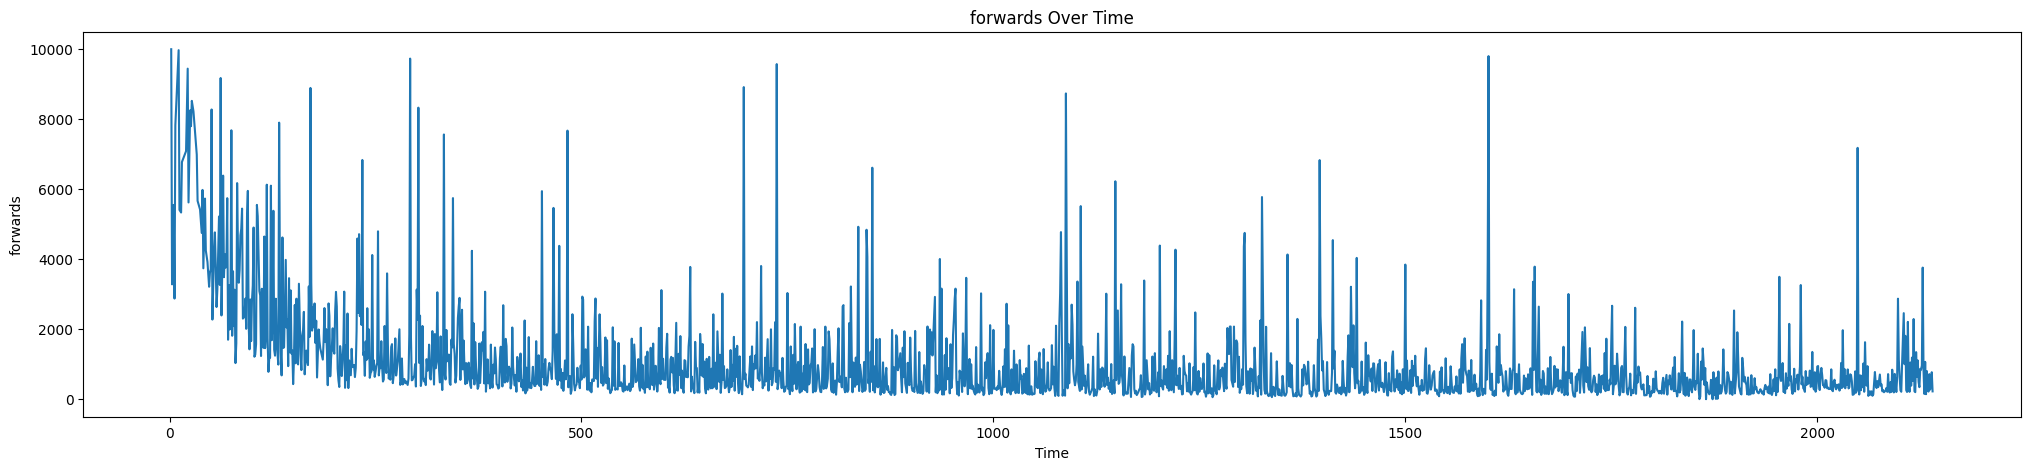

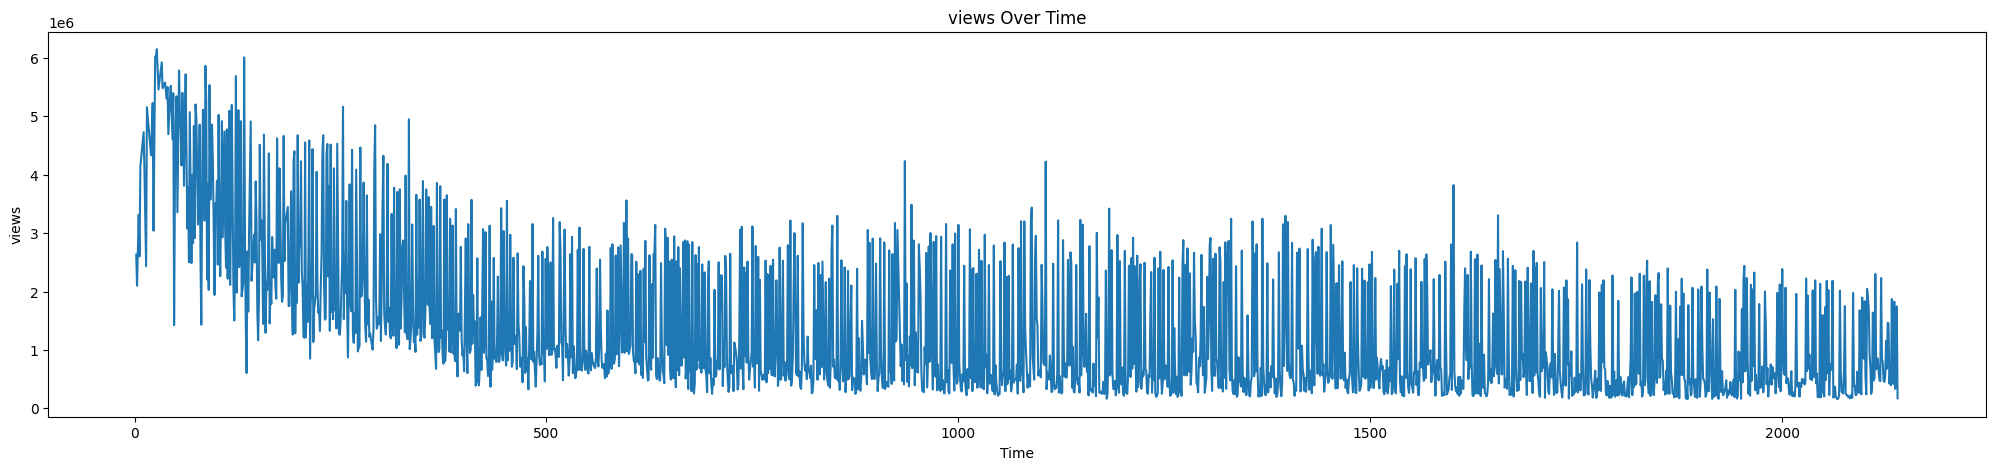

In [ ]:
# Differenced outcomes
vis_stationary('forwards')
vis_stationary('views')

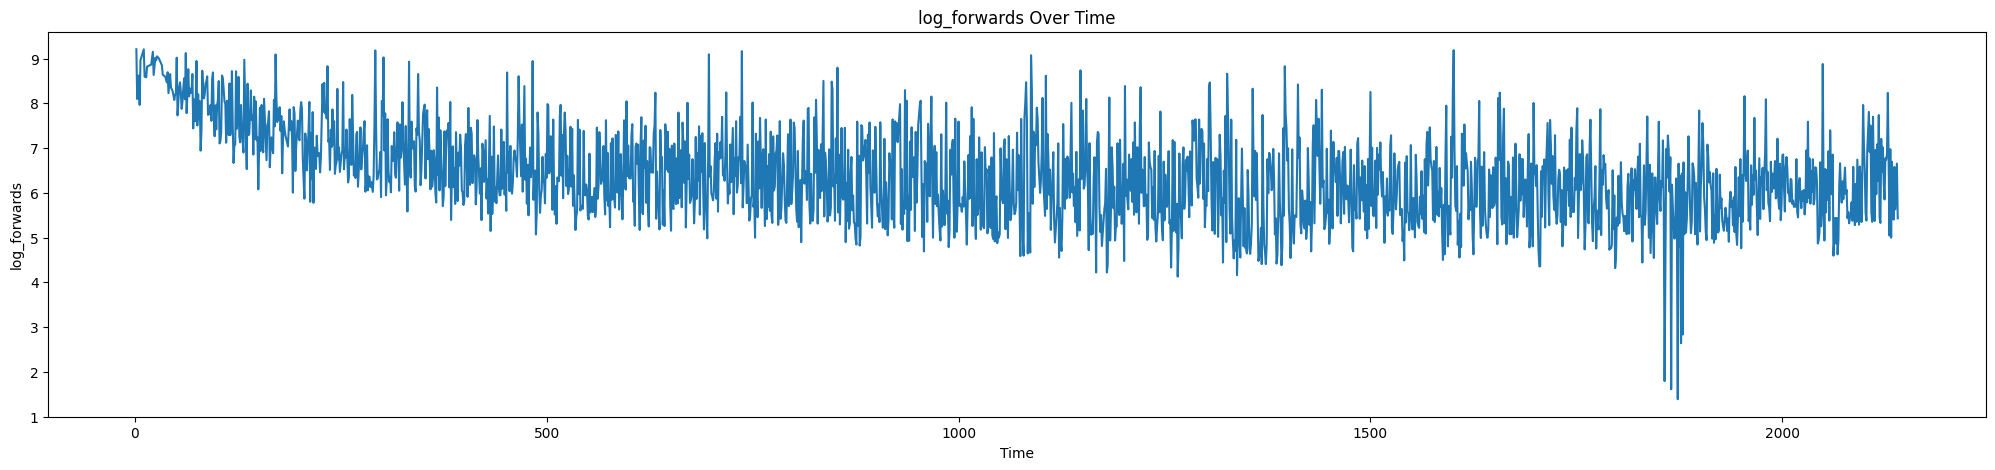

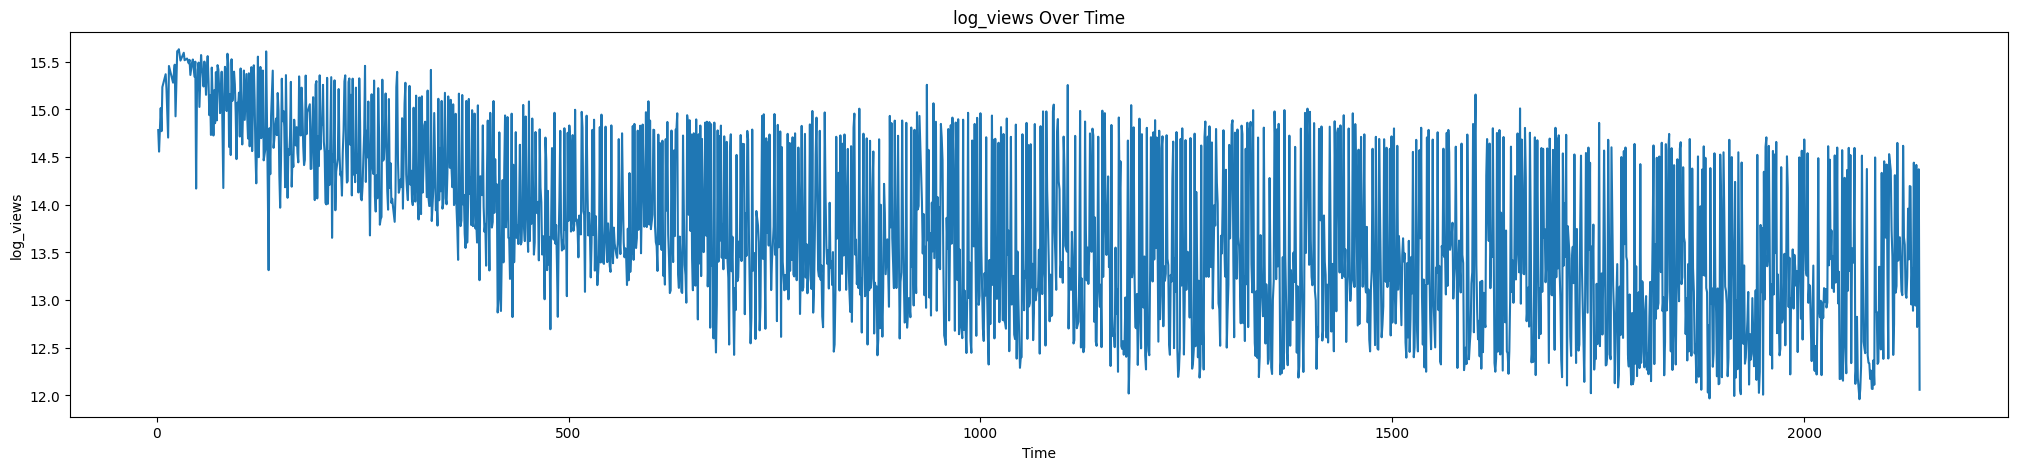

In [ ]:
# Log transformed data
vis_stationary('log_forwards')
vis_stationary('log_views')

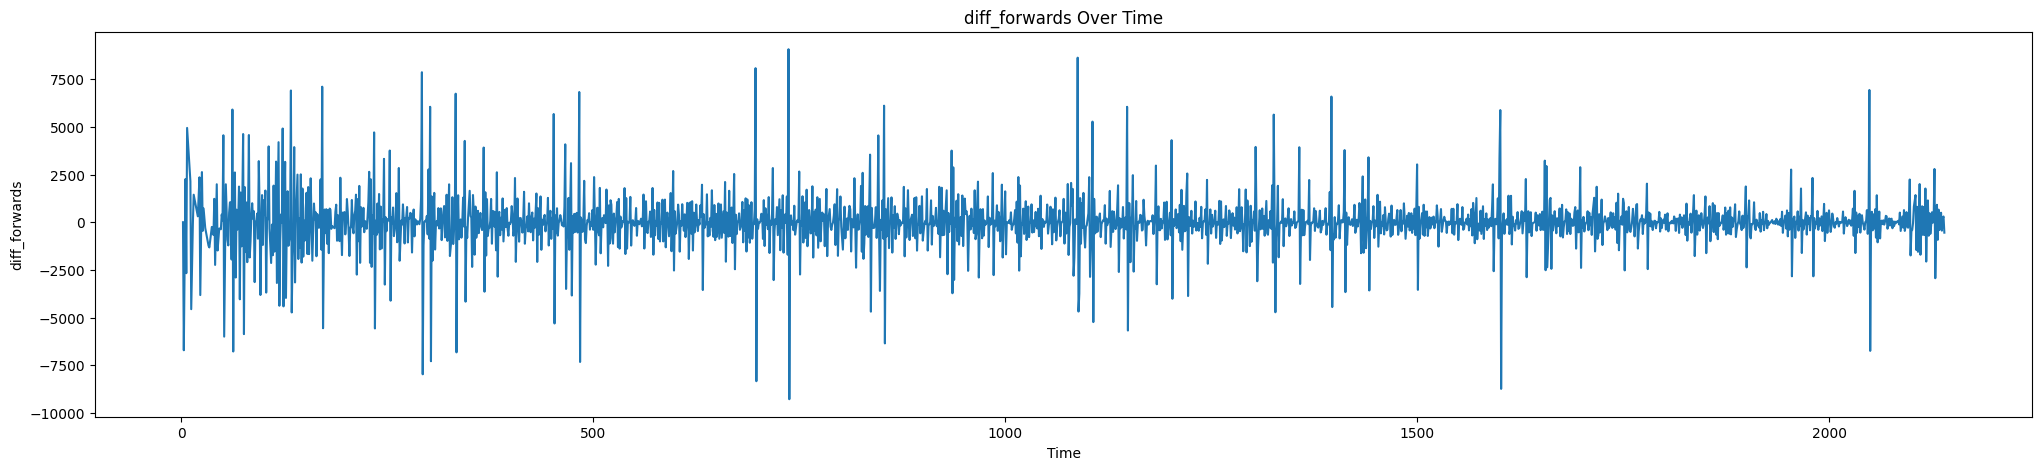

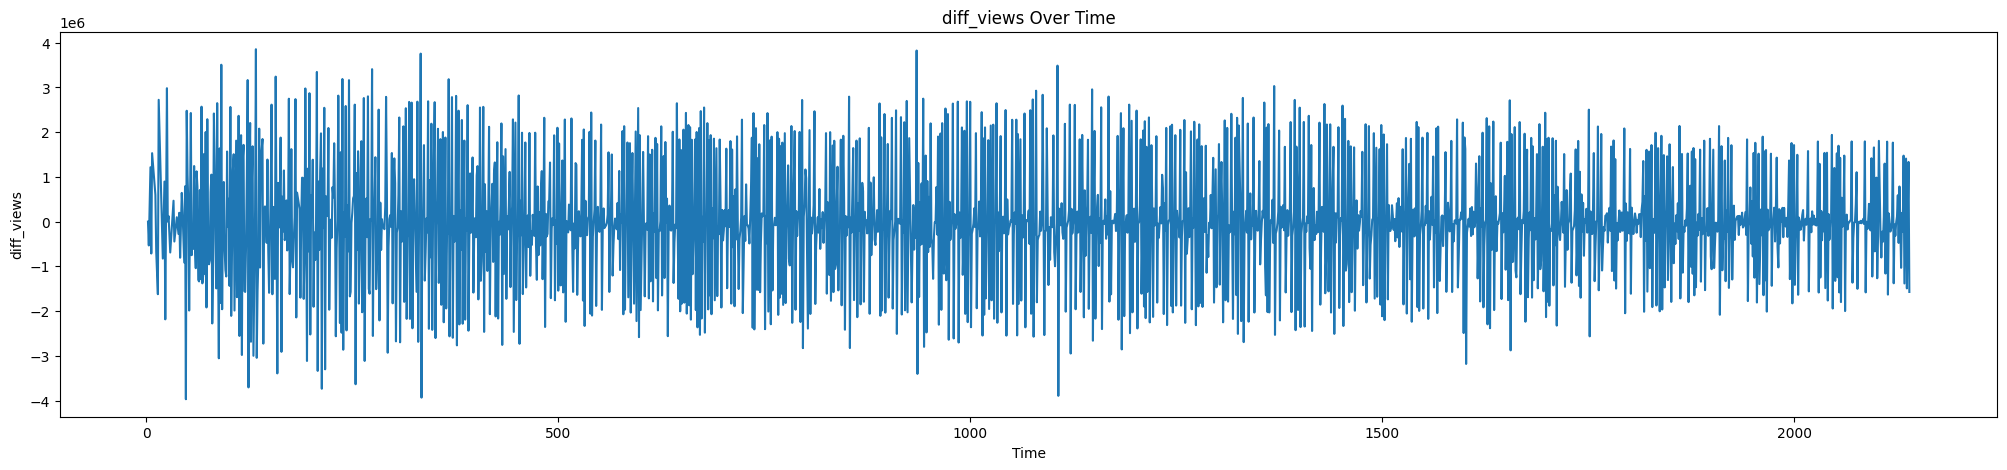

In [ ]:
# Differenced outcomes
vis_stationary('diff_forwards')
vis_stationary('diff_views')

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['1%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
print('Unit root test', sm.tsa.stattools.range_unit_root_test(df['forwards'], store=False))
check_stationarity(df['forwards'])
check_stationarity(df['views'])
check_stationarity(df['diff_forwards'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2189: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is larger than the p-value returned.

  warnings.warn(


Unit root test (0.6340407306976078, 0.01, {'10%': 1.45652, '5%': 1.3236716, '2.5%': 1.220874, '1%': 1.1128636})
ADF Statistic: -7.521706
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary
ADF Statistic: -5.338495
p-value: 0.000005
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary
ADF Statistic: -18.811815
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary


In [ ]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

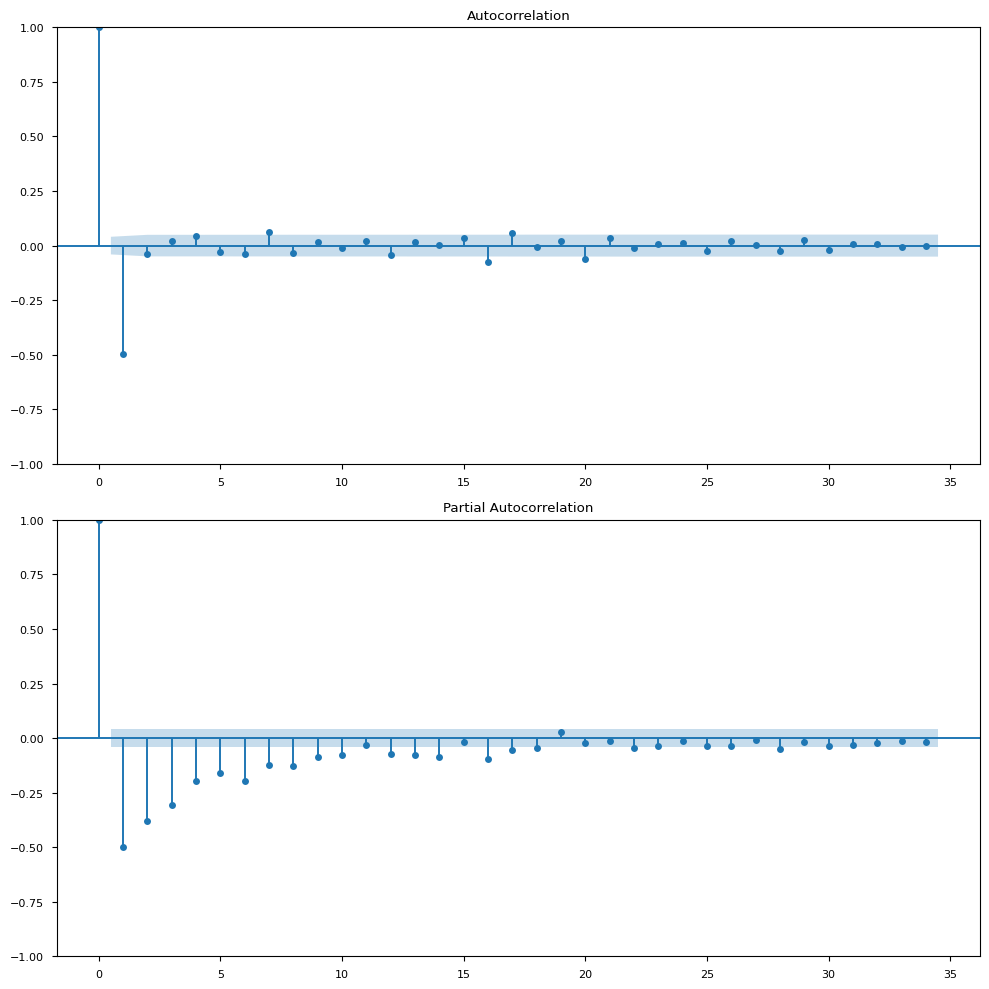

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
plot_acf(df['diff_views'][1:],ax=ax[0])
plot_pacf(df['diff_views'][1:], ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

- Functions start at t=0 where correlation is 1

## Select model


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [ ]:
def plot_residuals(model):
  residuals = arma_model.resid

  # Plot the residuals
  plt.figure(figsize=(25, 8))
  plt.plot(residuals)
  plt.title('Residuals from ARMA model')
  plt.xlabel('Time')
  plt.ylabel('Error')
  plt.show()

In [ ]:
df['topic_no_outliers'].value_counts()

0     208
2     195
1     147
3     112
5     107
4     107
7      99
20     91
6      89
8      86
14     75
12     74
9      70
10     67
18     62
11     58
13     58
19     54
15     53
16     51
17     47
29     45
24     44
21     43
23     39
22     39
25     39
27     35
28     35
26     33
30     32
32     30
31     27
Name: topic_no_outliers, dtype: int64

In [ ]:
# DO NOT CHANGE DF
def prep_time_data(outcome):
  df_out = df.copy()

  df_out = df_out[['views', 'forwards', 'diff_forwards', 'emotion_gpt', 'diff_views', 'log_forwards', 'log_views',
                   'mime_type', 'topic', 'x_weekofyear_cat', 'x_hour']]
  emotion_dummies = pd.get_dummies(df_out['emotion_gpt'], prefix='emotion')
  media_dummies = pd.get_dummies(df_out['mime_type'], prefix='media')
  topic_dummies = pd.get_dummies(df_out['topic'], prefix='topic')
  week_dummies = pd.get_dummies(df['x_weekofyear_cat'], prefix='week')
  hour_dummies = pd.get_dummies(df['x_hour'], prefix='hour')

  df_out = pd.concat([df_out,
                      emotion_dummies,
                      media_dummies,
                      topic_dummies],
                      # week_dummies,
                      # hour_dummies,
                      axis=1)

  print('N columns ', df_out.shape[0])

  exog = df_out.drop(['views' , 'forwards', 'diff_forwards', 'diff_views', 'log_forwards', 'log_views',
                      'emotion_gpt',
                      'emotion_neutral', # reference
                      'mime_type',
                      'media_text', # reference
                      'topic',
                      'topic_-1', # reference
                      #'week_0', # reference
                      'x_weekofyear_cat',
                      # 'hour_0',
                        'x_hour'],
                      axis=1)

  y = df_out[outcome]

  return y, exog, df_out

In [ ]:
# Get data
y, exog, _ = prep_time_data('log_forwards')

N columns  2351


KeyError: ignored

#### MR



In [ ]:
help(ARIMA)

In [ ]:
mr_model = ARIMA(endog = y,
                   order = (0,  0, 1),
                   exog = exog,
                   ).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(mr_model.summary())

                               SARIMAX Results                                
Dep. Variable:           log_forwards   No. Observations:                 2092
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2537.288
Date:                Fri, 07 Jul 2023   AIC                           5162.576
Time:                        17:54:55   BIC                           5410.995
Sample:                             0   HQIC                          5253.583
                               - 2092                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.7589      0.221     26.002      0.000       5.325       6.193
emotion_anger             0.7689      0.219      3.514      0.000       0.340       1.198
emotion_

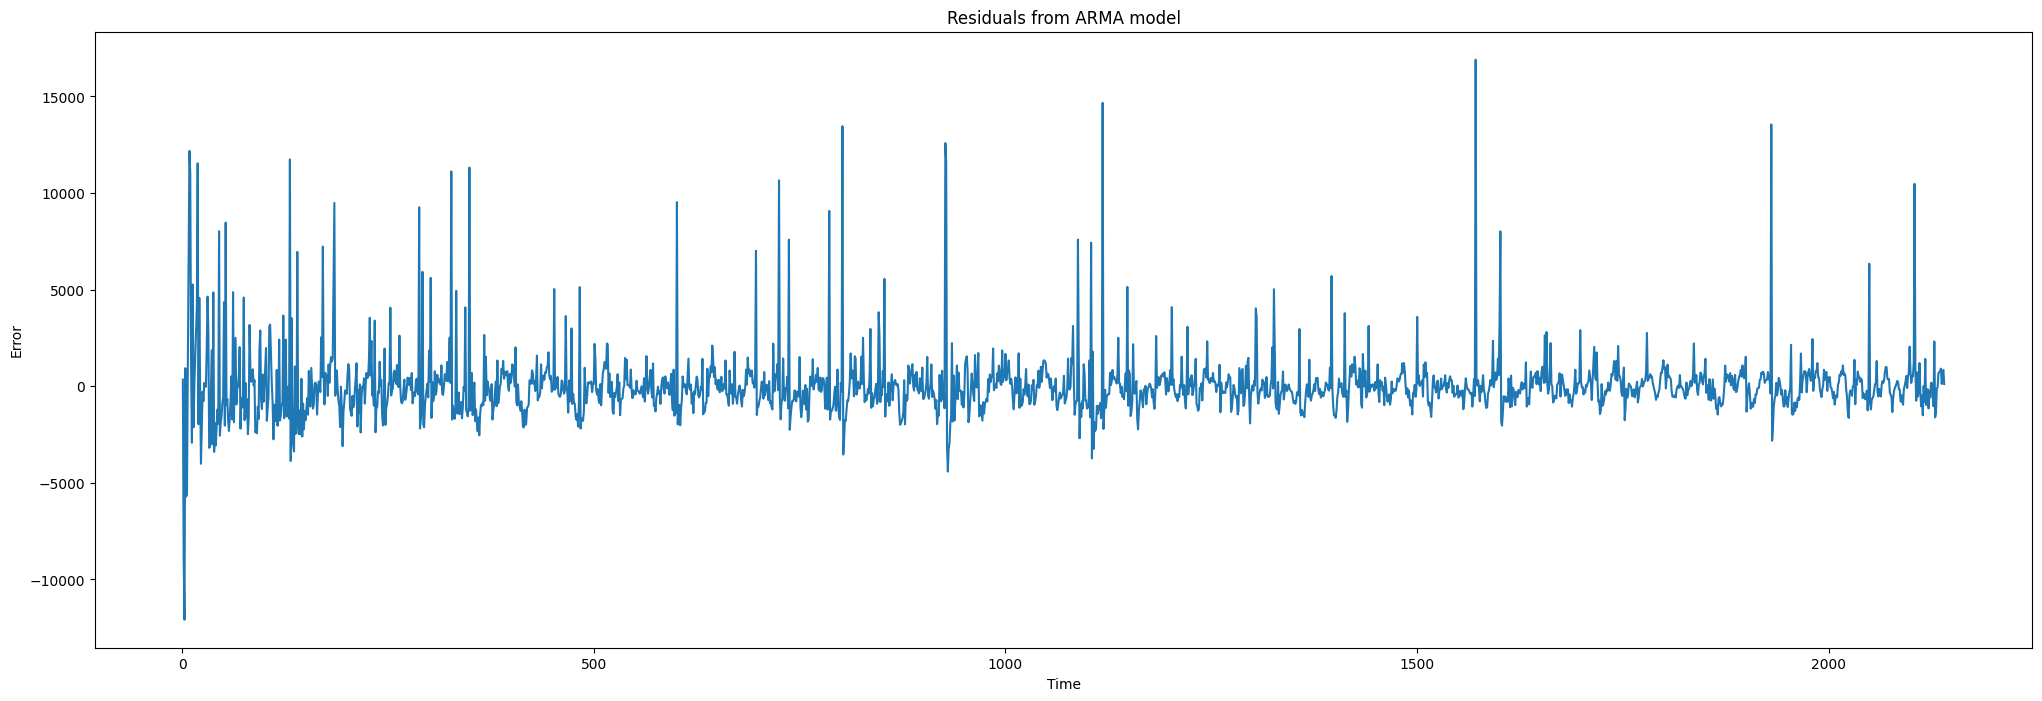

In [ ]:
plot_residuals(mr_model)

#### ARM

In [ ]:
arma_model = ARIMA(endog = y,
                   order = (2, 0 , 2),
                   exog = exog,
                   ).fit()

NameError: ignored

In [ ]:
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:               forwards   No. Observations:                 2141
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2313.295
Date:                Fri, 07 Jul 2023   AIC                           4902.589
Time:                        12:30:45   BIC                           5684.915
Sample:                             0   HQIC                          5188.854
                               - 2141                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.0266      3.076      2.609      0.009       1.997      14.056
emotion_anger             0.6141      0.217      2.831      0.005       0.189       1.039
emotion_

In [ ]:
# Compute DW of residuals
print(sm.stats.durbin_watson(arma_model.resid.values))

# Plot residuals
def plot_residuals(model):
  residuals = arma_model.resid

  # Plot the residuals
  plt.figure(figsize=(25, 8))
  plt.plot(residuals)
  plt.title('Residuals from ARMA model')
  plt.xlabel('Time')
  plt.ylabel('Error')
  plt.show()

plot_residuals(arma_model)

NameError: ignored

In [ ]:
import statsmodels.api as sm
import pandas as pd

# Create lagged variables
df['views_lag1'] = df['views'].shift(1)

# Create dummy variables for emotion categories
emotion_dummies = pd.get_dummies(df['emotion_gpt'], prefix='emotion')

# Create lagged dummy variables
emotion_dummies_lag1 = emotion_dummies.shift(1).rename(columns=lambda x: x + '_lag1')

# Add dummy variables and their lagged versions to the dataframe
df = pd.concat([df, emotion_dummies, emotion_dummies_lag1], axis=1)

# Drop missing values (which will be at the start of the data due to the lag)
#df = df.dropna()
df = df[df['emotion_neutral_lag1'].notna()]
print(df.shape)

# Set up the regression model
# Drop the original 'emotion' column, 'views' column and the first dummy to avoid multicollinearity
X = df.drop(['views', 'emotion_gpt', 'emotion_neutral', 'emotion_neutral_lag1'], axis=1)
X = sm.add_constant(X)  # Add a constant to the model
y = np.log(df['views'])

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print out the results
print(results.summary())


(2140, 140)


ValueError: ignored

In [ ]:
df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/df_final.csv')
df.shape

df = df[['views', 'emotion_gpt', 'topic', 'mime_type', 'x_weekofyear_cat',
         'x_hour']]

In [ ]:
np.unique(df['x_hour'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'date', 'message', 'views',
       'forwards', 'reactions', 'mime_type', '👍', '🙏', '❤', '😢',
       'Total_emoijs', 'message_both', 'message_split_en', 'message_split_uk',
       'message_lan', 'message_score', 'en_original', 'uk_trans',
       'message_final', 'emotion_label_lowe', 'emotion_score_lowe',
       'emotion_label_hart', 'emotion_score_hart', 'emotion_label_cardiff',
       'emotion_score_cardiff', 'topic', 'emotion_gpt', 'day_n', 'rolling_avg',
       'sentiment', 'x_nchars', 'x_contains_emoij', 'x_year', 'x_month',
       'x_weekofyear', 'x_monthofyear', 'x_day', 'x_weekday', 'x_hour',
       'x_weekofyear_cat', 'x_monthofyear_cat', 'russia',
       'flesch_reading_ease', 'smog_index', 'log_views', 'log_forwards',
       'log_Total_emoijs'],
      dtype='object')

In [ ]:
from statsmodels.tsa.api import ARDL

emotion_dummies = pd.get_dummies(df['emotion_gpt'], prefix='emotion')
media_dummies = pd.get_dummies(df['mime_type'], prefix='media')
topic_dummies = pd.get_dummies(df['topic'], prefix='topic')
week_dummies = pd.get_dummies(df['x_weekofyear_cat'], prefix='week')
hour_dummies = pd.get_dummies(df['x_hour'], prefix='hour')

df = pd.concat([df, emotion_dummies, media_dummies,
                topic_dummies, week_dummies,
                hour_dummies], axis=1)
df.shape

exog = df.drop(['emotion_gpt', 'views', 'emotion_neutral',
                'mime_type','media_text',
                'topic', 'topic_-1', 'week_0', 'x_weekofyear_cat',
                'hour_0', 'x_hour'], axis=1)
y = np.log(df[['views']])

exog.head()
# print(exog, y)

,emotion_anger,emotion_appreciation,emotion_concern,emotion_confidence,emotion_defiance,emotion_determination,emotion_gratitude,emotion_hope,emotion_pride,media_image/jpeg,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
lags = {k:0 if 'topic' in k else 0 for k in exog.columns}
# lags = {k: 0 for k in exog.columns if 'neutral' not in k and 'gpt' not in k}
lags

{'emotion_anger': 0,
 'emotion_appreciation': 0,
 'emotion_concern': 0,
 'emotion_confidence': 0,
 'emotion_defiance': 0,
 'emotion_determination': 0,
 'emotion_gratitude': 0,
 'emotion_hope': 0,
 'emotion_pride': 0,
 'media_image/jpeg': 0,
 'media_video/mp4': 0,
 'media_video/quicktime': 0,
 'topic_0': 0,
 'topic_1': 0,
 'topic_2': 0,
 'topic_3': 0,
 'topic_4': 0,
 'topic_5': 0,
 'topic_6': 0,
 'topic_7': 0,
 'topic_8': 0,
 'topic_9': 0,
 'topic_10': 0,
 'topic_11': 0,
 'topic_12': 0,
 'topic_13': 0,
 'topic_14': 0,
 'topic_15': 0,
 'topic_16': 0,
 'topic_17': 0,
 'topic_18': 0,
 'topic_19': 0,
 'topic_20': 0,
 'topic_21': 0,
 'topic_22': 0,
 'topic_23': 0,
 'topic_24': 0,
 'topic_25': 0,
 'topic_26': 0,
 'topic_27': 0,
 'topic_28': 0,
 'week_1': 0,
 'week_2': 0,
 'week_3': 0,
 'week_4': 0,
 'week_5': 0,
 'week_6': 0,
 'week_7': 0,
 'week_8': 0,
 'week_9': 0,
 'week_10': 0,
 'week_11': 0,
 'week_12': 0,
 'week_13': 0,
 'week_14': 0,
 'week_15': 0,
 'week_16': 0,
 'week_17': 0,
 'week_

In [ ]:
ardl_mode = ARDL(y,1, exog, lags).fit()
print(ardl_mode.summary())

                                                                                                                                                                                                                               ARDL Model Results                                                                                                                                                                                                                              
Dep. Variable:                                                                                                                                                                                                                                                                                                                                                                                                                   views   No. Observations:                 2141
Model:             ARDL(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
stargazer(ardl_mode)

NameError: ignored

# Aggregated TS

In [ ]:
# resample the df to make it TS worhty
def resampled_df():


  df_resample = df.copy()

  df_resample['date'] = pd.to_datetime(df_resample['date'])
  df_resample.set_index('date', inplace=True)
  df_resample.sort_index(inplace=True)

  df_resample = df_resample[(df_resample.index >= pd.Timestamp('2022-05-01', tz='UTC'))]

  df_resample = df_resample[['forwards', 'emotion_gpt', 'mime_type']]

  # 'night' from 00:00 to 05:59, 'morning' from 06:00 to 11:59,
  # 'afternoon' from 12:00 to 17:59, and 'evening' from 18:00 to 23:59
  df_resample['period_of_day'] = pd.cut(df_resample.index.hour,
                                        bins=[0, 6, 12, 18, 24],
                                        labels=['night', 'morning', 'afternoon', 'evening'],
                                        include_lowest=True)


  # Convert 'mime/type' and 'period_of_day' to dummy variables
  df_resample = pd.get_dummies(df_resample, columns=['mime_type', 'period_of_day', 'emotion_gpt'])

  # Now we need to redefine the emotion_columns and exog_columns lists to include the new dummy variables
  emotion_columns = [col for col in df_resample.columns if 'emotion_gpt' in col]
 #mime_type_columns = [col for col in df_resample.columns if 'mime/type' in col]
  #period_of_day_columns = [col for col in df_resample.columns if 'period_of_day' in col]
  exog_columns = emotion_columns # + mime_type_columns + period_of_day_columns

  # Resample and aggregate the data on a 3-day basis
  # Take the mean of 'forwards' and the count of each emotion, mime type, period of day, and month
  df_resample = df_resample.resample('W').agg({'forwards': 'mean', **{col: 'sum' for col in exog_columns}})

  #df_resample['year'] = df_resample.index.year
  #df_resample['month'] = df_resample.index.month + (df_resample['year'] - df_resample['year'].min()) * 12
  #df_resample = pd.get_dummies(df_resample, columns=['month'])

  exog_columns = exog_columns + [col for col in df_resample.columns if 'month' in col]
  #df_resample['forwards'] = df_resample['forwards'].diff().fillna(0) #

  return df_resample, exog_columns

In [ ]:
df_resample, exog_columns = resampled_df()

In [ ]:
df_resample

,forwards,emotion_gpt_anger,emotion_gpt_appreciation,emotion_gpt_concern,emotion_gpt_confidence,emotion_gpt_defiance,emotion_gpt_determination,emotion_gpt_gratitude,emotion_gpt_hope,emotion_gpt_neutral,emotion_gpt_pride
date,,,,,,,,,,,
2022-05-01 00:00:00+00:00,1797.333333,0,0,0,0,0,1,1,1,0,0
2022-05-08 00:00:00+00:00,1241.694444,4,3,2,3,2,5,10,4,1,2
2022-05-15 00:00:00+00:00,1391.259259,2,3,0,2,1,7,6,1,0,5
2022-05-22 00:00:00+00:00,1682.888889,0,2,0,2,1,7,5,6,0,4
2022-05-29 00:00:00+00:00,1107.115385,1,0,2,0,0,9,6,4,0,4
2022-06-05 00:00:00+00:00,854.800000,5,2,1,1,3,8,7,4,0,4
2022-06-12 00:00:00+00:00,722.233333,3,2,0,1,0,15,4,3,0,2
2022-06-19 00:00:00+00:00,1368.828571,1,2,2,3,0,9,13,3,0,2
2022-06-26 00:00:00+00:00,923.000000,0,2,2,0,0,8,7,5,0,1


In [ ]:
def anal_df(var, df=df_resample):


  plot_acf(df[var], lags=20, title=f'Autocorrelation Function for "{var}"')

# Plot the Partial Autocorrelation Function (PACF) for 'forwards'
  plot_pacf(df[var], lags=20, title=f'Partial Autocorrelation Function for "{var}"')

  plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
  plt.plot(df.index, df[var], color='blue')
  plt.xlabel('Time')
  plt.ylabel(f'{var}')
  plt.title(f'{var} Over Time')
  plt.grid(True)
  plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


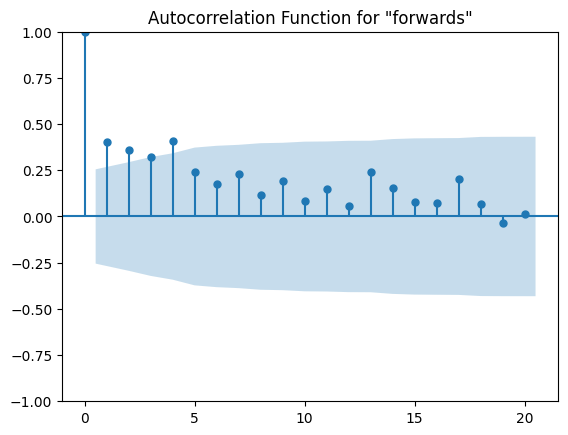

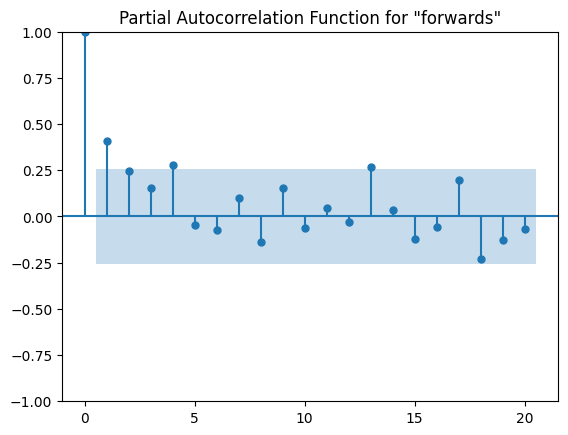

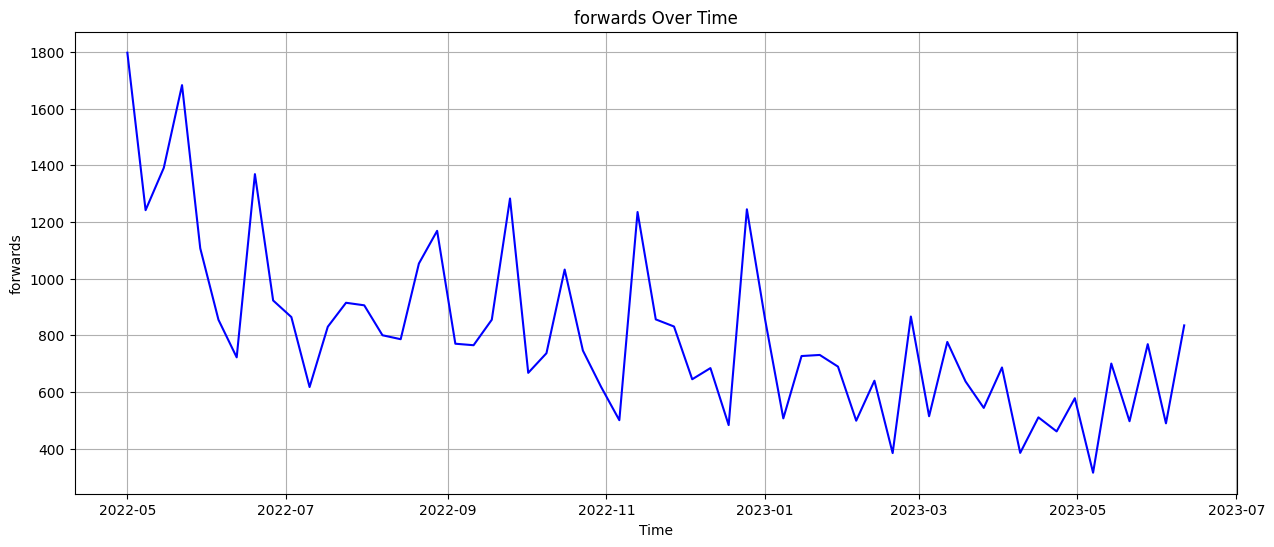

In [ ]:
anal_df('forwards')

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

def ts_anal(df=df_resample, exog=exog_columns):
  ts_model = AutoReg(df['forwards'], lags=1, exog=df[exog])
  ts_model = ts_model.fit()

  print(ts_model.summary())
# Get the residuals
  ts_model_residuals = ts_model.resid

  # Plot the ACF of the residuals
  plot_acf(ts_model_residuals, lags=20, title='Autocorrelation Plot of the Residuals (Weekly Interval)')

  # Plot the PACF of the residuals
  plot_pacf(ts_model_residuals, lags=20, title='Partial Autocorrelation Plot of the Residuals (Weekly Interval)')

                            AutoReg Model Results                             
Dep. Variable:               forwards   No. Observations:                   59
Model:                   AutoReg-X(1)   Log Likelihood                -397.122
Method:               Conditional MLE   S.D. of innovations            227.691
Date:                Sun, 09 Jul 2023   AIC                            856.244
Time:                        10:28:01   BIC                            920.117
Sample:                    05-08-2022   HQIC                           881.124
                         - 06-11-2023                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       294.9211    208.323      1.416      0.157    -113.384     703.227
forwards.L1                  -0.4462      0.115     -3.876      0.000      -0.672     

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


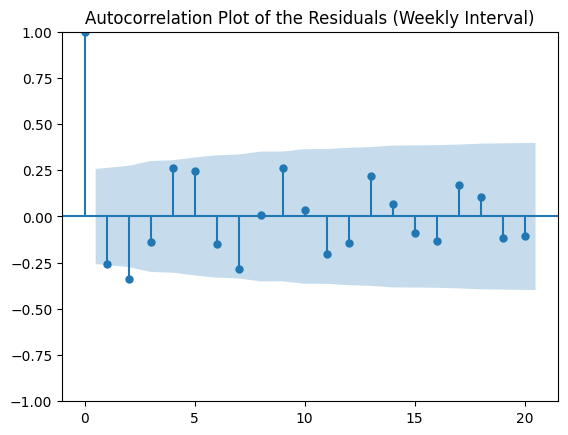

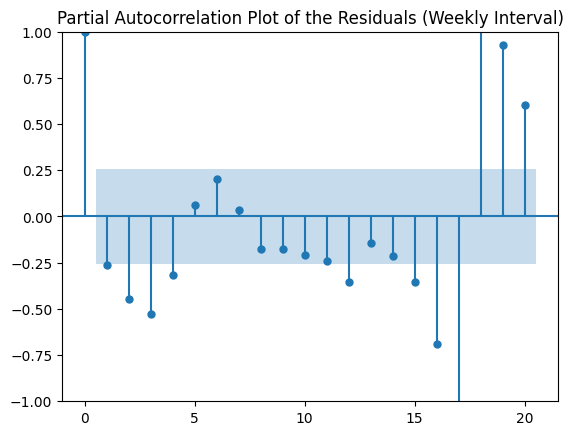

In [ ]:
ts_anal()

# Old Regression

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'date', 'message', 'views', 'forwards', 'reactions',
       'mime_type', '👍', '🙏', '❤', '😢', 'Total_emoijs', 'message_both',
       'message_split_en', 'message_split_uk', 'message_lan', 'message_score',
       'en_original', 'uk_trans', 'message_final', 'emotion_label_lowe',
       'emotion_score_lowe', 'emotion_label_hart', 'emotion_score_hart',
       'emotion_label_cardiff', 'emotion_score_cardiff', 'topic',
       'emotion_gpt', 'x_nchars', 'x_contains_emoij', 'x_year', 'x_month',
       'x_weekofyear', 'x_monthofyear', 'x_day', 'x_weekday', 'x_hour',
       'x_weekofyear_cat', 'x_monthofyear_cat', 'russia', 'log_views',
       'log_forwards', 'log_Total_emoijs'],
      dtype='object')

In [ ]:
# OLS: run regression
# Controls
#x_weekofyear_cat x_monthofyear_cat
controls = 'C(topic) + C(mime_type) + C(x_hour) + C(x_weekofyear_cat) + x_nchars + C(x_contains_emoij)'

# -- VIEWS
# cardiff
base_cardiff_views = f'views ~ C(emotion_label_cardiff, Treatment(reference="LABEL_1"))'
control_cardiff_views = f'views ~ C(emotion_label_cardiff, Treatment(reference="LABEL_1")) + {controls}'

# hart
base_hart_views = f'views ~ C(emotion_label_hart, Treatment(reference="neutral"))'
control_hart_views = f'views ~ C(emotion_label_hart, Treatment(reference="neutral")) + {controls}'

# gpt
base_gpt_views = f'views ~ C(emotion_gpt, Treatment(reference="neutral"))'
control_gpt_views = f'views ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

# -- FORWARDS
# Formula forwards cardiff
base_cardiff_forwards = f'forwards ~ C(emotion_label_cardiff, Treatment(reference="LABEL_1"))'
control_cardiff_forwards = f'forwards ~ C(emotion_label_cardiff, Treatment(reference="LABEL_1")) + {controls}'

# Formula forwards hart
base_hart_forwards = f'forwards ~ C(emotion_label_hart, Treatment(reference="neutral"))'
control_hart_forwards = f'forwards ~ C(emotion_label_hart, Treatment(reference="neutral")) + {controls}'

# gpt
base_gpt_forwards = f'forwards ~ C(emotion_gpt, Treatment(reference="neutral"))'
control_gpt_forwards = f'forwards ~ C(emotions_gpt, Treatment(reference="neutral")) + {controls}'

# -- Total emoijs
# Formula forwards cardiff
base_cardiff_tote = f'Total_emoijs ~ C(emotion_label_cardiff, Treatment(reference="LABEL_1"))'
control_cardiff_tote = f'Total_emoijs ~ C(emotion_label_cardiff, Treatment(reference="LABEL_1")) + {controls}'

# Formula forwards hart
base_hart_tote = f'Total_emoijs ~ C(emotion_label_hart, Treatment(reference="neutral"))'
control_hart_tote = f'Total_emoijs ~ C(emotion_label_hart, Treatment(reference="neutral")) + {controls}'

# gpt
base_gpt_tote = f'Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral"))'
control_gpt_tote = f'Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

# -- MODELS
ols_model = smf.ols(formula=control_hart_forwards, data=df).fit()

In [ ]:
# -- Run models for each specification

# sentiment views cardiff
ols_v_base_card = smf.ols(formula=base_cardiff_views, data=df).fit()
ols_v_control_card = smf.ols(formula=control_cardiff_views, data=df).fit()

# emotion views hart
ols_v_base_hart = smf.ols(formula=base_hart_views, data=df).fit()
ols_v_control_hart = smf.ols(formula=control_hart_views, data=df).fit()

# emotion views gpt
ols_v_base_gpt = smf.ols(formula=base_gpt_views, data=df).fit()
ols_v_control_gpt = smf.ols(formula=control_gpt_views, data=df).fit()

# sentiment forwards cardiff
ols_f_base_card = smf.ols(formula=base_cardiff_forwards, data=df).fit()
ols_f_control_card = smf.ols(formula=control_cardiff_forwards, data=df).fit()

# emotion forwards hart
ols_f_base_hart= smf.ols(formula=base_hart_forwards, data=df).fit()
ols_f_control_hart = smf.ols(formula=control_hart_forwards, data=df).fit()

# emotion forwards hart
ols_f_base_gpt = smf.ols(formula=base_gpt_forwards, data=df).fit()
ols_f_control_gpt = smf.ols(formula=control_gpt_forwards, data=df).fit()

# sentiment tote cardiff
ols_tote_base_card = smf.ols(formula=base_cardiff_tote, data=df_emoijs).fit()
ols_tote_control_card = smf.ols(formula=control_cardiff_tote, data=df_emoijs).fit()

# emotion tote hart
ols_tote_base_hart= smf.ols(formula=base_hart_tote, data=df_emoijs).fit()
ols_tote_control_hart = smf.ols(formula=control_hart_tote, data=df_emoijs).fit()

# emotion tote gpt
ols_tote_base_gpt= smf.ols(formula=base_gpt_tote, data=df_emoijs).fit()
ols_tote_control_gpt = smf.ols(formula=control_gpt_tote, data=df_emoijs).fit()

In [ ]:
# Aggregate models
views_summary = summary_col(results=[ols_v_base_card,
                                     ols_v_control_card,
                                     ols_v_base_hart,
                                     ols_v_control_hart,
                                     ols_v_base_gpt,
                                     ols_v_control_gpt],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Base Sentiment',
                                         'Control Sentiment',
                                         'Base Emotion',
                                         'Control Emotion',
                                         'Base Emotion GPT',
                                          'Control Emotion GPT'])
views_summary.add_title('OLS Regressions: Views')

forwards_summary = summary_col(results=[ols_f_base_card,
                                ols_f_control_card,
                                ols_f_base_hart,
                                ols_f_control_hart,
                                ols_f_base_gpt,
                                ols_f_control_gpt],
                              float_format='%0.2f',
                              stars = True,
                              model_names=['Base Sentiment',
                                            'Control Sentiment',
                                            'Base Emotion',
                                            'Control Emotion',
                                            'Base Emotion GPT',
                                            'Control Emotion GPT'])
forwards_summary.add_title('OLS Regression: Forwards')


tote_summary = summary_col(results=[ols_tote_base_card,
                                ols_tote_control_card,
                                ols_tote_base_hart,
                                ols_tote_control_hart,
                                ols_tote_base_gpt,
                                ols_tote_control_gpt],
                              float_format='%0.2f',
                              stars = True,
                              model_names=['Base Sentiment',
                                            'Control Sentiment',
                                            'Base Emotion',
                                            'Control Emotion',
                                            'Base Emotion GPT',
                                            'Control Emotion GPT'])
tote_summary.add_title('OLS Regression: Total Emoijs (change in N!)')

In [ ]:
# Show results
print(views_summary)

                                                                        OLS Regressions: Views
                                                                    Base Sentiment Control Sentiment  Base Emotion Control Emotion Base Emotion GPT Control Emotion GPT
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
C(emotion_gpt, Treatment(reference="neutral"))[T.admiration]                                                                       771666.79**      -155506.47         
                                                                                                                                   (371922.87)      (213204.95)        
C(emotion_gpt, Treatment(reference="neutral"))[T.anger]                                                                            1393779.85***    238947.19          
                                                                 

In [ ]:
# Output to Table folder
# Save views
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Output/Tables/views_regs.html', 'w') as file:
    file.write(views_summary.as_html())

# Save forwards
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Output/Tables/forwards_regs.html', 'w') as file:
    file.write(forwards_summary.as_html())

# Save tote
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Output/Tables/tote_regs.html', 'w') as file:
    file.write(tote_summary.as_html())